In [ ]:
import os
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#pip install matplotlib==3.5.3

TESTS

In [ ]:
# test_gender_pipeline.py
from google.colab import drive
import sys
import os
import pandas as pd

# Mount Drive
drive.mount('/content/drive')

# Set paths based on your actual directory structure
PROJECT_ROOT = '/content/drive/My Drive/anonymised_CVs_classification'
MODULE_PATH = os.path.join(PROJECT_ROOT, 'modules')
CONFIG_PATH = os.path.join(PROJECT_ROOT, 'attribute_configs')

# Add paths to sys.path
sys.path.append(MODULE_PATH)
sys.path.append(CONFIG_PATH)

# Import modules directly (not as packages)
try:
    # Direct imports after adding to sys.path
    import data_utils
    import gender_config

    print("✅ Imports successful!")

    # Let's first print the available methods in the modules to confirm imports work
    print("\nAvailable methods in data_utils:")
    for method in dir(data_utils):
        if not method.startswith('_'):
            print(f"- {method}")

    # Let's also check the gender config
    print("\nGender mappings from config:")
    print(gender_config.ATTRIBUTE_MAPPINGS)

except ImportError as e:
    print(f"❌ Import error: {e}")
    print(f"Current sys.path: {sys.path}")
    print(f"Files in MODULE_PATH: {os.listdir(MODULE_PATH) if os.path.exists(MODULE_PATH) else 'Path not found'}")
    print(f"Files in CONFIG_PATH: {os.listdir(CONFIG_PATH) if os.path.exists(CONFIG_PATH) else 'Path not found'}")

print("\nTest complete")

Mounted at /content/drive
✅ Imports successful!

Available methods in data_utils:
- Any
- Dict
- List
- Optional
- Tuple
- create_dataset_from_pairs
- create_train_val_test_split
- defaultdict
- explore_directory_structure
- extract_attribute_from_raw
- generate_attribute_dataset
- glob
- json
- match_files_by_person
- organize_files_by_person
- os
- pd
- re
- save_dataset

Gender mappings from config:
{'Man': 'Male', 'Male': 'Male', 'männlich': 'Male', 'mann': 'Male', 'Woman': 'Female', 'Female': 'Female', 'weiblich': 'Female', 'frau': 'Female'}

Test complete


REAL ATTEMPT 🤞

Uses existing directory structure and modules.

Processes the data step by step, saving intermediate results.

Tests both mBERT and XLM-RoBERTa on the gender prediction task.

Compares the performance of both models

In [ ]:
!pip install huggingface_hub[hf_xet]
# Run this script in your Colab notebook to fix the import issue
file_path = '/content/drive/My Drive/anonymised_CVs_classification/modules/model_utils.py'

with open(file_path, 'r') as file:
    content = file.read()

# Replace the problematic line and add the correct imports
if '#from transformers import AdamW, get_linear_schedule_with_warmup' in content:
    content = content.replace('#from transformers import AdamW, get_linear_schedule_with_warmup',
                             'from torch.optim import AdamW\nfrom transformers import get_linear_schedule_with_warmup')
elif 'from transformers import AdamW, get_linear_schedule_with_warmup' in content:
    content = content.replace('from transformers import AdamW, get_linear_schedule_with_warmup',
                             'from torch.optim import AdamW\nfrom transformers import get_linear_schedule_with_warmup')
elif '#from transformers import get_linear_schedule_with_warmup' in content:
    # If the line is already commented out but we still have AdamW being used
    content = content.replace('#from transformers import get_linear_schedule_with_warmup',
                             'from torch.optim import AdamW\nfrom transformers import get_linear_schedule_with_warmup')

# Write the fixed content back to the file
with open(file_path, 'w') as file:
    file.write(content)

print(f"Updated {file_path} with the correct imports")
print("Now check the file to confirm changes with:")
print("!grep -A 5 -B 5 'AdamW' " + file_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 15.9 MB/s eta 0:00:00
Updated /content/drive/My Drive/anonymised_CVs_classification/modules/model_utils.py with the correct imports
Now check the file to confirm changes with:
!grep -A 5 -B 5 'AdamW' /content/drive/My Drive/anonymised_CVs_classification/modules/model_utils.py


In [ ]:
# Fix the indentation in model_utils.py
import os

# Get the correct path to the project
PROJECT_ROOT = '/content/drive/My Drive/anonymised_CVs_classification'
model_utils_path = os.path.join(PROJECT_ROOT, 'modules', 'model_utils.py')

# Read the file line by line
with open(model_utils_path, 'r') as file:
    lines = file.readlines()

# Find the train_model function
in_train_model = False
fixed_lines = []
for line in lines:
    if "def train_model(" in line:
        in_train_model = True
        fixed_lines.append(line)
    elif in_train_model and line.strip() == "from torch.optim import AdamW":
        fixed_lines.append("    from torch.optim import AdamW\n")
    elif in_train_model and line.strip() == "from transformers import get_linear_schedule_with_warmup":
        fixed_lines.append("    from transformers import get_linear_schedule_with_warmup\n")
    else:
        fixed_lines.append(line)

# Write the corrected file
with open(model_utils_path, 'w') as file:
    file.writelines(fixed_lines)

print(f"Fixed indentation in {model_utils_path}")

Fixed indentation in /content/drive/My Drive/anonymised_CVs_classification/modules/model_utils.py


don't really need to run this guy, is here for debugging

In [ ]:
# Add this at the beginning of your main code cell
def fix_dataset_mismatch():
    # 1. First, define a patched version of the CVDataset class
    class PatchedCVDataset(torch.utils.data.Dataset):
        def __init__(self, df, tokenizer, max_length=512):
            self.df = df
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            text = str(self.df.iloc[idx]['optimized_text'])
            label = self.df.iloc[idx]['label']

            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Return both 'label' and 'labels' to satisfy both versions
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long),
                'labels': torch.tensor(label, dtype=torch.long)
            }

    # 2. Create a patched evaluate function to fix model_utils
    def patched_evaluate_model(model, test_loader, device, label_names):
        """Patched version that handles both 'label' and 'labels'"""
        # Custom evaluate implementation
        all_preds = []
        all_labels = []
        total_loss = 0

        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                # Get inputs and handle both label versions
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                # Try labels first, fall back to label if needed
                try:
                    if 'labels' in batch:
                        labels = batch['labels'].to(device)
                    else:
                        labels = batch['label'].to(device)
                except KeyError:
                    print("Warning: Both 'label' and 'labels' missing from batch")
                    continue

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()

                # Get predictions
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
        test_accuracy = accuracy_score(all_labels, all_preds)
        test_f1 = f1_score(all_labels, all_preds, average='weighted')
        test_precision = precision_score(all_labels, all_preds, average='weighted')
        test_recall = recall_score(all_labels, all_preds, average='weighted')

        # Return results
        results = {
            'test_loss': total_loss / len(test_loader),
            'test_accuracy': test_accuracy,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'confusion_matrix': confusion_matrix(all_labels, all_preds),
            'predictions': all_preds,
            'true_labels': all_labels
        }

        return results

    # Return the patched components
    return PatchedCVDataset, patched_evaluate_model

# Get the patched components
PatchedCVDataset, patched_evaluate_model = fix_dataset_mismatch()

# Replace the original versions with patched ones
CVDataset = PatchedCVDataset
# Override the module's function with our patched version
import types
model_utils.evaluate_model = types.MethodType(patched_evaluate_model, model_utils)

NameError: name 'model_utils' is not defined

# Gender Prediction Summary  
**Content**: Sets up a Colab environment for gender classification from CV text, including data mounting, preprocessing (cleaning, class distribution analysis), and advanced model training with multiple transformer architectures (mBERT, RoBERTa, DistilBERT).  
**Process**: Implements data splits, custom tokenization, hyperparameter tuning, gradient handling, and model evaluation with metrics (accuracy, F1, precision, recall).  



\\
**Results**: Best model (DistilBERT) achieved 63.8% test accuracy and 0.6376 F1 score, outperforming mBERT (51.8%) and RoBERTa (61.4%). Includes class imbalance visualization and performance comparisons.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Consider using Google Colab with GPU runtime for faster training.
Step 1: Extract raw files and match with parsed files
Loaded existing base dataset from /content/drive/My Drive/anonymised_CVs_classification/data/base_data.csv
Base dataset has 921 records

Step 2: Extract gender information from raw files
Loaded existing gender data from /content/drive/My Drive/anonymised_CVs_classification/data/gender/gender_raw.csv
Gender dataset has 921 records

Step 3: Generate gender dataset with CV text
Loaded existing gender dataset from /content/drive/My Drive/anonymised_CVs_classification/data/gender/gender_dataset.csv
Processed gender dataset has 821 records

Analyzing gender distribution:

Gender Distribution Analysis:
Total samples: 821

Percentage distribution:
gender
Female    51.64
Male      48.36
Name: proportion, dtype: float64

Absolute counts:
gender
Female    424
Male      397
Name: count, dtype: int64


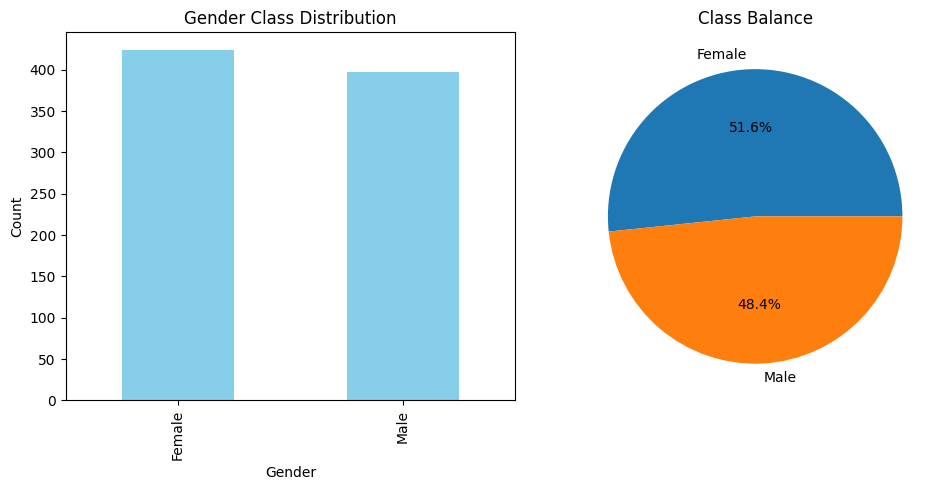


Step 4: Create train/val/test splits
Loaded existing train/val/test splits
Train: 656 records, Val: 82 records, Test: 83 records

Step 5: Training and evaluating models with enhanced configuration...

Preparing data for mBERT...

Preparing data for bert-base-multilingual-cased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Loaded existing optimized train data for bert-base-multilingual-cased
Loaded existing optimized val data for bert-base-multilingual-cased
Loaded existing optimized test data for bert-base-multilingual-cased
Data prepared for bert-base-multilingual-cased with max_length=512

Training and evaluating base mBERT model...

Training and evaluating bert-base-multilingual-cased model with advanced settings
Learning rate: 3e-05, Batch size: 16, Weight decay: 0.01
Dropout: 0.2, Warmup ratio: 0.1, Scheduler: cosine
Gradient accumulation: 2, Gradient clipping: 1.0


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu
Loading existing model from /content/drive/My Drive/anonymised_CVs_classification/models/gender/bert_base_multilingual_cased_lr3e-05_bs16_wd0.01_do0.2.pt
Evaluating on test set...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test accuracy: 0.5181
Test F1 score: 0.3536
Test precision: 0.2684
Test recall: 0.5181

Preparing data for roberta-base...

Preparing data for roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Loaded existing optimized train data for roberta-base
Loaded existing optimized val data for roberta-base
Loaded existing optimized test data for roberta-base
Data prepared for roberta-base with max_length=512

Training and evaluating roberta-base model...

Training and evaluating roberta-base model with advanced settings
Learning rate: 3e-05, Batch size: 16, Weight decay: 0.01
Dropout: 0.2, Warmup ratio: 0.1, Scheduler: cosine
Gradient accumulation: 2, Gradient clipping: 1.0


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu
Loading existing model from /content/drive/My Drive/anonymised_CVs_classification/models/gender/roberta_base_lr3e-05_bs16_wd0.01_do0.2.pt
Evaluating on test set...
Test accuracy: 0.6145
Test F1 score: 0.6146
Test precision: 0.6154
Test recall: 0.6145

Preparing data for distilbert-base-uncased...

Preparing data for distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Loaded existing optimized train data for distilbert-base-uncased
Loaded existing optimized val data for distilbert-base-uncased
Loaded existing optimized test data for distilbert-base-uncased
Data prepared for distilbert-base-uncased with max_length=512

Training and evaluating distilbert-base-uncased model...

Training and evaluating distilbert-base-uncased model with advanced settings
Learning rate: 3e-05, Batch size: 16, Weight decay: 0.01
Dropout: 0.2, Warmup ratio: 0.1, Scheduler: cosine
Gradient accumulation: 2, Gradient clipping: 1.0


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu
Loading existing model from /content/drive/My Drive/anonymised_CVs_classification/models/gender/distilbert_base_uncased_lr3e-05_bs16_wd0.01_do0.2.pt
Evaluating on test set...
Test accuracy: 0.6386
Test F1 score: 0.6376
Test precision: 0.6434
Test recall: 0.6386

Comparing all model performance:
bert-base-multilingual-cased: Acc: 0.5181, F1: 0.3536
roberta-base: Acc: 0.6145, F1: 0.6146
distilbert-base-uncased: Acc: 0.6386, F1: 0.6376

RECOMMENDED MODEL: distilbert-base-uncased with F1 score: 0.6376

Gender prediction pipeline completed with enhanced models!


In [ ]:
# Gender Prediction - Enhanced Colab Script
# Modified to work on both Colab and local environments (VS Code)
import sys
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import importlib.util
import re
from sklearn.model_selection import ParameterGrid
from transformers import (
    BertTokenizer,
    XLMRobertaTokenizer,
    RobertaTokenizer,
    DebertaTokenizer,
    DistilBertTokenizer,
    AlbertTokenizer,
    LongformerTokenizer,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from torch.optim import AdamW
import numpy as np

# --------------------------------------
# Check environment and setup accordingly
# --------------------------------------
def is_colab_environment():
    """Check if the code is running in Google Colab"""
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Setup paths based on environment
if is_colab_environment():
    from google.colab import drive
    drive.mount('/content/drive')
    # Handle space in "My Drive" and add project root to Python path
    PROJECT_ROOT = '/content/drive/My Drive/anonymised_CVs_classification'
    RAW_DATA_PATH = '/content/drive/My Drive/submissions'  # Path to raw CV data
else:
    # Local environment paths - UPDATE THESE FOR YOUR LOCAL SETUP
    PROJECT_ROOT = os.path.abspath(os.path.dirname(__file__))  # Current directory
    RAW_DATA_PATH = os.path.join(PROJECT_ROOT, 'submissions')  # Update as needed

sys.path.append(PROJECT_ROOT)  # Add project root to Python path

# Create necessary directories
if is_colab_environment():
    # Create __init__.py files for package recognition (run once)
    !touch "{PROJECT_ROOT}/modules/__init__.py"
    !touch "{PROJECT_ROOT}/attribute_configs/__init__.py"
else:
    # For local environment, create directories if they don't exist
    os.makedirs(os.path.join(PROJECT_ROOT, 'modules'), exist_ok=True)
    os.makedirs(os.path.join(PROJECT_ROOT, 'attribute_configs'), exist_ok=True)

    # Create __init__.py files if they don't exist
    for path in [os.path.join(PROJECT_ROOT, 'modules/__init__.py'),
                 os.path.join(PROJECT_ROOT, 'attribute_configs/__init__.py')]:
        if not os.path.exists(path):
            with open(path, 'w') as f:
                pass  # Create empty file

# --------------------------------------
# 0. New Gender Distribution Analysis Function
# --------------------------------------
def analyze_gender_distribution(df, target_col='gender'):
    """Analyze and visualize class distribution"""
    # Calculate percentages
    distribution = df[target_col].value_counts(normalize=True) * 100
    counts = df[target_col].value_counts()

    # Print analysis
    print("\nGender Distribution Analysis:")
    print(f"Total samples: {len(df)}")
    print("\nPercentage distribution:")
    print(distribution.round(2))
    print("\nAbsolute counts:")
    print(counts)

    # Plot visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    counts.plot(kind='bar', color='skyblue')
    plt.title('Gender Class Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    distribution.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Class Balance')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# --------------------------------------
# 1. Set Remaining Paths
# --------------------------------------
DATA_PATH = os.path.join(PROJECT_ROOT, 'data')
MODELS_PATH = os.path.join(PROJECT_ROOT, 'models')

# Create directories if they don't exist
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(os.path.join(DATA_PATH, 'gender'), exist_ok=True)
os.makedirs(os.path.join(MODELS_PATH, 'gender'), exist_ok=True)

# Set specific paths for gender processing
GENDER_DATA_DIR = os.path.join(DATA_PATH, 'gender')
GENDER_MODEL_DIR = os.path.join(MODELS_PATH, 'gender')

# --------------------------------------
# 2. Import Modules Using Absolute Paths
# --------------------------------------
# Use explicit package paths
try:
    from modules import data_utils, text_utils, model_utils, viz_utils
    from attribute_configs import gender_config
except ImportError:
    print("Error importing modules. Make sure your project structure is correct.")
    print(f"PROJECT_ROOT is set to: {PROJECT_ROOT}")
    print("You may need to create/update the modules and attribute_configs packages.")
    sys.exit(1)

#######
# Add this at the beginning of your main code cell
def fix_dataset_mismatch():
    # 1. First, define a patched version of the CVDataset class
    class PatchedCVDataset(torch.utils.data.Dataset):
        def __init__(self, df, tokenizer, max_length=512):
            self.df = df
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            text = str(self.df.iloc[idx]['optimized_text'])
            label = self.df.iloc[idx]['label']

            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Return both 'label' and 'labels' to satisfy both versions
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long),
                'labels': torch.tensor(label, dtype=torch.long)
            }

    # 2. Create a patched evaluate function to fix model_utils
    def patched_evaluate_model(model, test_loader, device, label_names):
        """Patched version that handles both 'label' and 'labels'"""
        # Custom evaluate implementation
        all_preds = []
        all_labels = []
        total_loss = 0

        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                # Get inputs and handle both label versions
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                # Try labels first, fall back to label if needed
                try:
                    if 'labels' in batch:
                        labels = batch['labels'].to(device)
                    else:
                        labels = batch['label'].to(device)
                except KeyError:
                    print("Warning: Both 'label' and 'labels' missing from batch")
                    continue

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()

                # Get predictions
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
        test_accuracy = accuracy_score(all_labels, all_preds)
        test_f1 = f1_score(all_labels, all_preds, average='weighted')
        test_precision = precision_score(all_labels, all_preds, average='weighted')
        test_recall = recall_score(all_labels, all_preds, average='weighted')

        # Return results
        results = {
            'test_loss': total_loss / len(test_loader),
            'test_accuracy': test_accuracy,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'confusion_matrix': confusion_matrix(all_labels, all_preds),
            'predictions': all_preds,
            'true_labels': all_labels
        }

        return results

    # Return the patched components
    return PatchedCVDataset, patched_evaluate_model

# Get the patched components
PatchedCVDataset, patched_evaluate_model = fix_dataset_mismatch()

# Replace the original versions with patched ones
CVDataset = PatchedCVDataset
# Override the module's function with our patched version
import types
model_utils.evaluate_model = patched_evaluate_model

########

# --------------------------------------
# Device Configuration - NEW
# --------------------------------------
def get_device_with_warning():
    """Get the appropriate device (GPU or CPU) and provide warning if necessary"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("GPU is available! Using CUDA.")
    else:
        device = torch.device('cpu')
        print("WARNING: GPU is not available. Using CPU instead which will be much slower for training.")
        print("Consider using Google Colab with GPU runtime for faster training.")

    return device

# Call this to get device
device = get_device_with_warning()

print("Step 1: Extract raw files and match with parsed files")
# Check if we already have the base data
base_data_path = os.path.join(DATA_PATH, 'base_data.csv')
if not os.path.exists(base_data_path):
    # Organize files by person
    person_directories = data_utils.organize_files_by_person(RAW_DATA_PATH)

    # Match files
    matched_pairs, unmatched_raw_files = data_utils.match_files_by_person(person_directories)

    # Create dataset from matched pairs
    base_df = data_utils.create_dataset_from_pairs(matched_pairs)

    # Save base dataset
    base_df.to_csv(base_data_path, index=False)
    print(f"Base dataset created and saved to {base_data_path}")
else:
    # Load existing base data
    base_df = pd.read_csv(base_data_path)
    print(f"Loaded existing base dataset from {base_data_path}")

print(f"Base dataset has {len(base_df)} records")

print("\nStep 2: Extract gender information from raw files")
# Path for gender-specific data
gender_raw_path = os.path.join(GENDER_DATA_DIR, 'gender_raw.csv')

if not os.path.exists(gender_raw_path):
    # Extract gender from raw files using mapping from config
    gender_df = data_utils.extract_attribute_from_raw(
        base_df, 'select-6', gender_config.ATTRIBUTE_MAPPINGS
    )
    gender_df.to_csv(gender_raw_path, index=False)
    print(f"Gender data extracted and saved to {gender_raw_path}")
else:
    # Load existing gender data
    gender_df = pd.read_csv(gender_raw_path)
    print(f"Loaded existing gender data from {gender_raw_path}")

print(f"Gender dataset has {len(gender_df)} records")

print("\nStep 3: Generate gender dataset with CV text")
# Path for the processed gender dataset
gender_dataset_path = os.path.join(GENDER_DATA_DIR, 'gender_dataset.csv')

if not os.path.exists(gender_dataset_path):
    # Generate gender dataset with CV text
    gender_dataset = data_utils.generate_attribute_dataset(
        gender_df,
        attribute_field='select-6_mapped',
        attribute_name='Gender',
        attribute_column='gender',
        output_csv_path=gender_dataset_path
    )
else:
    # Load existing processed dataset
    gender_dataset = pd.read_csv(gender_dataset_path)
    print(f"Loaded existing gender dataset from {gender_dataset_path}")

print(f"Processed gender dataset has {len(gender_dataset)} records")

print("\nAnalyzing gender distribution:")
analyze_gender_distribution(gender_dataset)

print("\nStep 4: Create train/val/test splits")
# Paths for train/val/test splits
train_path = os.path.join(GENDER_DATA_DIR, 'gender_train.csv')
val_path = os.path.join(GENDER_DATA_DIR, 'gender_val.csv')
test_path = os.path.join(GENDER_DATA_DIR, 'gender_test.csv')

if not os.path.exists(train_path) or not os.path.exists(val_path) or not os.path.exists(test_path):
    # Create splits
    train_df, val_df, test_df = data_utils.create_train_val_test_split(
        gender_dataset,
        target_column='gender',
        output_dir=GENDER_DATA_DIR,
        prefix='gender'
    )
else:
    # Load existing splits
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    print("Loaded existing train/val/test splits")

print(f"Train: {len(train_df)} records, Val: {len(val_df)} records, Test: {len(test_df)} records")

# --------------------------------------
# 5. Enhanced CV Text Cleaning Function
# --------------------------------------
def clean_cv_text(df, text_column):
    '''Apply CV-specific cleaning to text data'''
    df = df.copy()

    # Function to clean text
    def clean(text):
        if not isinstance(text, str):
            return ""

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)

        # Remove email addresses (common in CVs)
        text = re.sub(r'\S+@\S+', '[EMAIL]', text)

        # Remove phone numbers (common in CVs)
        text = re.sub(r'\+?[\d\s()-]{8,}', '[PHONE]', text)

        # Replace URLs
        text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)

        # Clean up bullet points for better tokenization
        text = re.sub(r'•|◦|▪|●', '- ', text)

        # Standardize newlines
        text = re.sub(r'\n+', ' [NEWLINE] ', text)

        # Identify personal titles and preserve them (potentially gender-relevant)
        text = re.sub(r'\b(Mr|Mrs|Ms|Miss|Dr|Prof)\b\.?', r'[TITLE_\1]', text)

        # Normalize spacing around special tokens
        text = re.sub(r'\[([A-Z_]+)\]', r' [\1] ', text)
        text = re.sub(r'\s+', ' ', text)

        return text.strip()

    df[text_column] = df[text_column].apply(clean)
    return df

# --------------------------------------
# 6. Custom Dataset for CV text data
# --------------------------------------
class CVDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.iloc[idx]['optimized_text'])
        label = self.df.iloc[idx]['label']

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# --------------------------------------
# 7. Advanced Training Function with device-aware saving
# --------------------------------------
def train_model_advanced(model, train_loader, val_loader, optimizer, scheduler,
                         num_epochs, device, model_save_path, gradient_accumulation_steps=1,
                         gradient_clipping=1.0, early_stopping_patience=3):
    '''Advanced training loop with gradient accumulation, clipping, and early stopping'''
    # Initialize tracking variables
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_acc = 0, 0
        optimizer.zero_grad()

        for batch_idx, batch in enumerate(train_loader):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / gradient_accumulation_steps  # Normalize loss
            loss.backward()

            # Only update every gradient_accumulation_steps steps
            if (batch_idx + 1) % gradient_accumulation_steps == 0 or batch_idx == len(train_loader) - 1:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

                # Update parameters
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            # Calculate metrics
            train_loss += loss.item() * gradient_accumulation_steps
            preds = torch.argmax(outputs.logits, dim=1)
            train_acc += (preds == labels).sum().item() / len(labels)

        # Average metrics
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0, 0

        with torch.no_grad():
            for batch in val_loader:
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                # Calculate metrics
                val_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                val_acc += (preds == labels).sum().item() / len(labels)

        # Average metrics
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)

        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            # Save best model - MODIFIED TO BE DEVICE-AWARE
            torch.save({
                'model_state_dict': model.state_dict(),
                'device': str(device)
            }, model_save_path)
            print(f'Model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch+1}. Best epoch was {best_epoch+1}.')
                break

    # Load best model with device mapping
    checkpoint = torch.load(model_save_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    return metrics

# --------------------------------------
# 8. Create Optimized Model Function
# --------------------------------------
def create_optimized_model(model_name, num_labels, dropout_rate=0.2):
    """Create a pre-trained transformer model with the specified configuration"""
    if 'bert-base-multilingual' in model_name.lower():
        from transformers import BertForSequenceClassification
        model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
    elif 'xlm-roberta' in model_name.lower():
        from transformers import XLMRobertaForSequenceClassification
        model = XLMRobertaForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
    elif 'roberta' in model_name.lower():
        from transformers import RobertaForSequenceClassification
        model = RobertaForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
    elif 'deberta' in model_name.lower():
        from transformers import DebertaForSequenceClassification
        model = DebertaForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
    elif 'distilbert' in model_name.lower():
        from transformers import DistilBertForSequenceClassification
        model = DistilBertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            dropout=dropout_rate
        )
    elif 'albert' in model_name.lower():
        from transformers import AlbertForSequenceClassification
        model = AlbertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
    elif 'longformer' in model_name.lower():
        from transformers import LongformerForSequenceClassification
        model = LongformerForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    return model

# --------------------------------------
# 9. Enhanced Training and Evaluation Function with device handling
# --------------------------------------
def train_and_evaluate_model_advanced(
    model_name,
    train_df,
    val_df,
    test_df,
    tokenizer,
    learning_rate=3e-5,
    batch_size=16,
    weight_decay=0.01,
    dropout_rate=0.2,
    warmup_ratio=0.1,
    max_epochs=10,
    scheduler_type='cosine',
    gradient_accumulation_steps=1,
    gradient_clipping=1.0,
    early_stopping_patience=3
):
    print(f"\nTraining and evaluating {model_name} model with advanced settings")
    print(f"Learning rate: {learning_rate}, Batch size: {batch_size}, Weight decay: {weight_decay}")
    print(f"Dropout: {dropout_rate}, Warmup ratio: {warmup_ratio}, Scheduler: {scheduler_type}")
    print(f"Gradient accumulation: {gradient_accumulation_steps}, Gradient clipping: {gradient_clipping}")

    # Create label mapping from data (moved inside the function)
    unique_genders = sorted(train_df['gender'].unique())
    label_map = {gender: i for i, gender in enumerate(unique_genders)}
    inv_label_map = {i: gender for gender, i in label_map.items()}

    # Convert labels
    train_df['label'] = train_df['gender'].map(label_map)
    val_df['label'] = val_df['gender'].map(label_map)
    test_df['label'] = test_df['gender'].map(label_map)

    # Create model with specified dropout
    model = create_optimized_model(
        model_name=model_name,
        num_labels=len(unique_genders),
        dropout_rate=dropout_rate
    )

    # Use the global device
    global device
    print(f"Using device: {device}")
    model.to(device)

    # Create datasets and dataloaders with specified batch size
    from torch.utils.data import DataLoader
    train_dataset = CVDataset(train_df, tokenizer)
    val_dataset = CVDataset(val_df, tokenizer)
    test_dataset = CVDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Define model output path with hyperparameters
    model_prefix = model_name.split('/')[-1].replace("-", "_")
    model_save_path = os.path.join(
        GENDER_MODEL_DIR,
        f'{model_prefix}_lr{learning_rate}_bs{batch_size}_wd{weight_decay}_do{dropout_rate}.pt'
    )

    # Train model with advanced settings
    if not os.path.exists(model_save_path) or gender_config.RETRAIN:
        start_time = time.time()

        # Create AdamW optimizer with weight decay
        optimizer = AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        # Calculate total training steps for scheduler
        total_steps = len(train_loader) * max_epochs // gradient_accumulation_steps
        warmup_steps = int(total_steps * warmup_ratio)

        # Create learning rate scheduler
        if scheduler_type == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=warmup_steps,
                num_training_steps=total_steps
            )
        else:  # cosine
            scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps=warmup_steps,
                num_training_steps=total_steps
            )

        # Train with advanced features
        metrics = train_model_advanced(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=max_epochs,
            device=device,
            model_save_path=model_save_path,
            gradient_accumulation_steps=gradient_accumulation_steps,
            gradient_clipping=gradient_clipping,
            early_stopping_patience=early_stopping_patience
        )

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
    else:
        print(f"Loading existing model from {model_save_path}")
        # Load with device mapping
        checkpoint = torch.load(model_save_path, map_location=device)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        metrics = None  # No metrics available for loaded model

    # Evaluate on test set
    print("Evaluating on test set...")
    test_results = model_utils.evaluate_model(
        model=model,
        test_loader=test_loader,
        device=device,
        label_names=unique_genders
    )

    print(f"Test accuracy: {test_results['test_accuracy']:.4f}")
    print(f"Test F1 score: {test_results['test_f1']:.4f}")
    print(f"Test precision: {test_results['test_precision']:.4f}")
    print(f"Test recall: {test_results['test_recall']:.4f}")

    # Create visualizations
    if metrics:
        viz_utils.visualize_model_performance(
            metrics=metrics,
            test_results=test_results,
            class_names=unique_genders,
            output_dir=os.path.join(GENDER_MODEL_DIR, 'plots'),
            prefix=f"{model_prefix}_"
        )

    return test_results, model_save_path

# --------------------------------------
# 10. Prepare Data for Models
# --------------------------------------
def prepare_data_for_model(model_name, max_length=512):
    print(f"\nPreparing data for {model_name}")

    # Enhanced tokenizer selection
    if 'bert-base-multilingual' in model_name.lower():
        tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        model_suffix = 'mbert'
    elif 'xlm-roberta' in model_name.lower():
        tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
        model_suffix = 'xlmr'
    elif 'roberta' in model_name.lower():
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
        model_suffix = 'roberta'
    elif 'deberta' in model_name.lower():
        tokenizer = DebertaTokenizer.from_pretrained(model_name)
        model_suffix = 'deberta'
    elif 'distilbert' in model_name.lower():
        tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        model_suffix = 'distilbert'
    elif 'albert' in model_name.lower():
        tokenizer = AlbertTokenizer.from_pretrained(model_name)
        model_suffix = 'albert'
    elif 'longformer' in model_name.lower():
        tokenizer = LongformerTokenizer.from_pretrained(model_name)
        model_suffix = 'longformer'
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    # Create paths for optimized data
    train_opt_path = os.path.join(GENDER_DATA_DIR, f'gender_train_{model_suffix}.csv')
    val_opt_path = os.path.join(GENDER_DATA_DIR, f'gender_val_{model_suffix}.csv')
    test_opt_path = os.path.join(GENDER_DATA_DIR, f'gender_test_{model_suffix}.csv')

    # Process data if not already done
    if not os.path.exists(train_opt_path):
        # First clean the text using CV-specific cleaning
        cleaned_train_df = clean_cv_text(train_df.copy(), 'cv_text')
        # Then process with the prepare_texts_for_transformers function
        train_opt = text_utils.prepare_texts_for_transformers(
            cleaned_train_df, 'cv_text', tokenizer,
            max_length=max_length
        )
        train_opt.to_csv(train_opt_path, index=False)
    else:
        train_opt = pd.read_csv(train_opt_path)
        print(f"Loaded existing optimized train data for {model_name}")

    if not os.path.exists(val_opt_path):
        cleaned_val_df = clean_cv_text(val_df.copy(), 'cv_text')
        val_opt = text_utils.prepare_texts_for_transformers(
            cleaned_val_df, 'cv_text', tokenizer,
            max_length=max_length
        )
        val_opt.to_csv(val_opt_path, index=False)
    else:
        val_opt = pd.read_csv(val_opt_path)
        print(f"Loaded existing optimized val data for {model_name}")

    if not os.path.exists(test_opt_path):
        cleaned_test_df = clean_cv_text(test_df.copy(), 'cv_text')
        test_opt = text_utils.prepare_texts_for_transformers(
            cleaned_test_df, 'cv_text', tokenizer,
            max_length=max_length
        )
        test_opt.to_csv(test_opt_path, index=False)
    else:
        test_opt = pd.read_csv(test_opt_path)
        print(f"Loaded existing optimized test data for {model_name}")

    print(f"Data prepared for {model_name} with max_length={max_length}")
    return train_opt, val_opt, test_opt, tokenizer

# --------------------------------------
# 11. Training Configuration
# --------------------------------------
training_config = {
    # Model selection (using better alternatives to XLM-RoBERTa)
    'models': [
        'bert-base-multilingual-cased',  # Keep the best performer
        'roberta-base',                  # Better than XLM-RoBERTa for many tasks
        'distilbert-base-uncased',       # Lighter and faster BERT variant
    ],

    # Hyperparameter options
    'learning_rates': [3e-5],
    'batch_sizes': [16],
    'weight_decays': [0.01],
    'dropout_rates': [0.2],
    'warmup_ratios': [0.1],

    # Training settings
    'max_epochs': 10,
    'early_stopping_patience': 3,
    'scheduler': 'cosine',  # 'linear' or 'cosine'
    'gradient_accumulation_steps': 2,
    'gradient_clipping': 1.0,

    # Maximum sequence length
    'max_length': 512
}

# --------------------------------------
# 12. Train and Evaluate Models
# --------------------------------------
print("\nStep 5: Training and evaluating models with enhanced configuration...")
# Initialize results tracking
all_results = {}

# Create model_data dictionary
model_data = {}

# First prepare data for mBERT (our base model)
print("\nPreparing data for mBERT...")
mbert_key = 'bert-base-multilingual-cased'
train_opt, val_opt, test_opt, tokenizer = prepare_data_for_model(mbert_key, max_length=training_config['max_length'])
model_data[mbert_key] = (train_opt, val_opt, test_opt, tokenizer)

# Train and evaluate mBERT (keep your best performer)
print("\nTraining and evaluating base mBERT model...")
mbert_results, _ = train_and_evaluate_model_advanced(
    model_name=mbert_key,
    train_df=model_data[mbert_key][0],
    val_df=model_data[mbert_key][1],
    test_df=model_data[mbert_key][2],
    tokenizer=model_data[mbert_key][3],
    learning_rate=training_config['learning_rates'][0],
    batch_size=training_config['batch_sizes'][0],
    weight_decay=training_config['weight_decays'][0],
    dropout_rate=training_config['dropout_rates'][0],
    warmup_ratio=training_config['warmup_ratios'][0],
    max_epochs=training_config['max_epochs'],
    scheduler_type=training_config['scheduler'],
    gradient_accumulation_steps=training_config['gradient_accumulation_steps'],
    gradient_clipping=training_config['gradient_clipping'],
    early_stopping_patience=training_config['early_stopping_patience']
)
all_results[mbert_key] = mbert_results

# Train and evaluate alternative models
alternative_models = [
    'roberta-base',            # Better than XLM-RoBERTa for many tasks
    'distilbert-base-uncased'  # Try a smaller, faster model
]

for model_name in alternative_models:
    model_key = model_name  # Use full model name as key
    print(f"\nPreparing data for {model_name}...")

    try:
        # Prepare data for this model
        train_opt, val_opt, test_opt, tokenizer = prepare_data_for_model(model_name, max_length=training_config['max_length'])
        model_data[model_key] = (train_opt, val_opt, test_opt, tokenizer)

        print(f"\nTraining and evaluating {model_name} model...")
        # Train with default hyperparameters
        results, _ = train_and_evaluate_model_advanced(
            model_name=model_name,
            train_df=model_data[model_key][0],
            val_df=model_data[model_key][1],
            test_df=model_data[model_key][2],
            tokenizer=model_data[model_key][3],
            learning_rate=training_config['learning_rates'][0],
            batch_size=training_config['batch_sizes'][0],
            weight_decay=training_config['weight_decays'][0],
            dropout_rate=training_config['dropout_rates'][0],
            warmup_ratio=training_config['warmup_ratios'][0],
            max_epochs=training_config['max_epochs'],
            scheduler_type=training_config['scheduler'],
            gradient_accumulation_steps=training_config['gradient_accumulation_steps'],
            gradient_clipping=training_config['gradient_clipping'],
            early_stopping_patience=training_config['early_stopping_patience']
        )

        all_results[model_key] = results

         # Separate try-except for visualization
        try:
            if 'metrics' in locals() and metrics:
                viz_utils.visualize_model_performance(
                    metrics=metrics,
                    test_results=results,
                    class_names=unique_genders,
                    output_dir=os.path.join(GENDER_MODEL_DIR, 'plots'),
                    prefix=f"{model_name.split('/')[-1].replace('-', '_')}_"
                )
        except Exception as viz_error:
            print(f"Visualization error for {model_name}: {str(viz_error)}")
            # Continue anyway since results are already stored

    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
        print("Skipping to next model...")
        continue

# Compare all models
print("\nComparing all model performance:")
for model_name, results in all_results.items():
    print(f"{model_name}: Acc: {results['test_accuracy']:.4f}, F1: {results['test_f1']:.4f}")

# Recommend best model
if all_results:
    best_model = max(all_results.items(), key=lambda x: x[1]['test_f1'])
    print(f"\nRECOMMENDED MODEL: {best_model[0]} with F1 score: {best_model[1]['test_f1']:.4f}")
else:
    print("No models were successfully evaluated.")

print("\nGender prediction pipeline completed with enhanced models!")

this guy is the same but it uses GPU only, kept as backup gg

In [ ]:
#while True:pass

In [ ]:
!pip install shifterator

import nltk
nltk.download('punkt_tab')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 13.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Shifterator for Gender


Performing Gender Language Analysis with Shifterator
----------------------------------------------------

Step 1: Preparing texts by gender

Step 2: Creating word frequency dictionaries

Vocabulary Statistics:
Male CVs: 70688 total words, 8214 unique words
Female CVs: 62455 total words, 7374 unique words

Step 3: Analyzing word proportion shifts
Analyzing word shifts between Male and Female CVs
Creating proportion shift...
Generating word shift graph for top 50 words...


/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


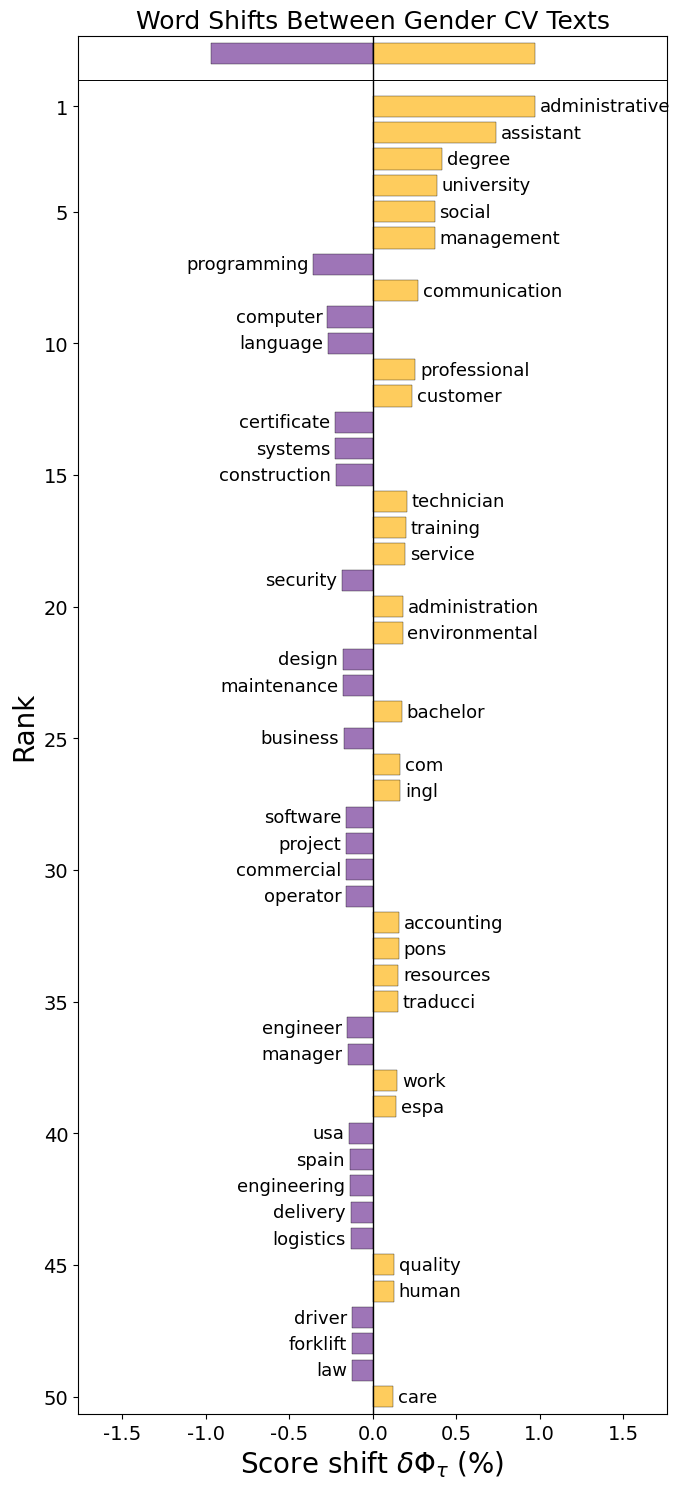


----- PROPORTION SHIFT EXPLANATION -----
What this graph shows:
- The words that are used with notably different frequencies between Male and Female CVs
- Bars extending right indicate words used MORE by the SECOND gender
- Bars extending left indicate words used MORE by the FIRST gender
- The length of each bar shows how much that word contributes to the overall difference

Most distinctive words for Female: administrative, assistant, degree, university, social
Most distinctive words for Male: programming, computer, language, certificate, systems

What this suggests:
- Female CVs tend to emphasize: administrative, assistant, degree, university, social
- Male CVs tend to emphasize: programming, computer, language, certificate, systems
- These differences may reflect gender-based variations in how people present their professional experiences
- They may also indicate differences in industry representation, roles, or educational backgrounds

Creating Jensen-Shannon Divergence shift...
G

/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


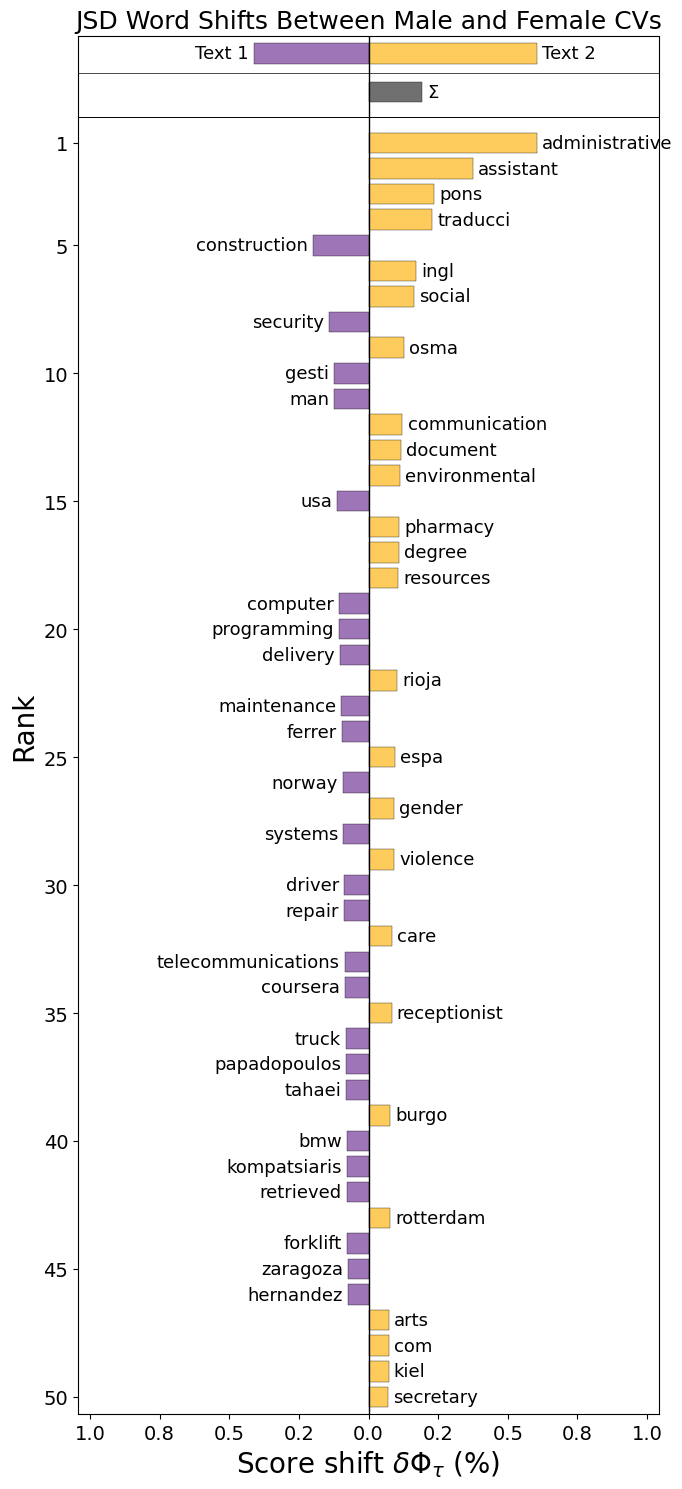


----- JENSEN-SHANNON DIVERGENCE EXPLANATION -----
What this graph shows:
- Information-theoretic differences between gender groups' language patterns
- JSD measures how distinct two probability distributions are from each other
- Unlike proportion shift, JSD is sensitive to both common and rare words
- Words with high JSD contribution create 'surprise' when moving between language models

Most information-rich distinguishing words: administrative, assistant, pons, traducci, construction, ingl, social, security, osma, gesti

What this suggests:
- These words create the most 'surprise' when reading CVs from one gender vs. another
- They represent meaningful differences in self-presentation between genders
- JSD-highlighted words may better represent genuine gender differences than simple frequency differences

Step 4: Analyzing sentiment shifts
Analyzing sentiment shifts between Male and Female CVs using custom CV lexicon
Generating sentiment shift graph...


/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


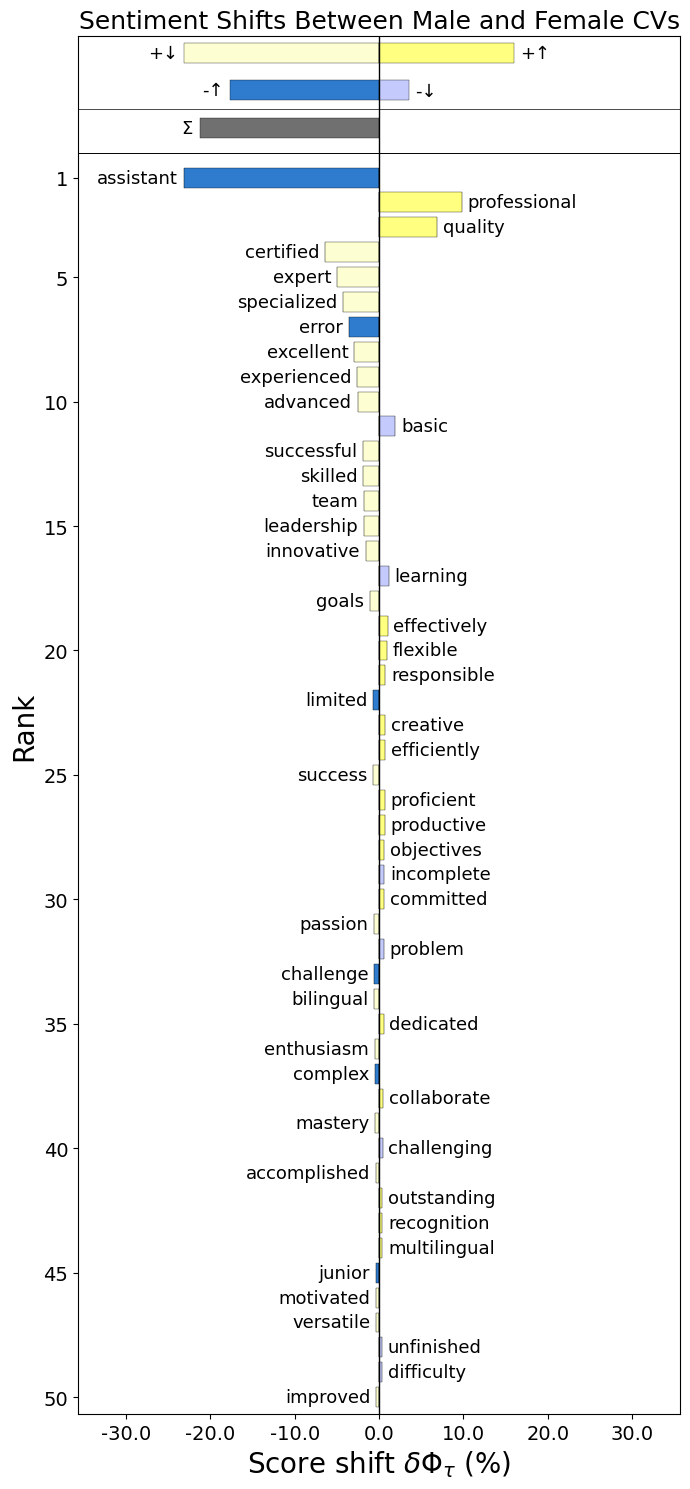


----- SENTIMENT ANALYSIS EXPLANATION -----
Average sentiment score for Male CVs: 0.0882
Average sentiment score for Female CVs: 0.0655
Sentiment difference: -0.0227

What this sentiment shift graph shows:
- Words that contribute to sentiment differences between gender groups
- Bars extending right indicate words making the SECOND gender more positive
- Bars extending left indicate words making the FIRST gender more positive
- The color coding indicates whether a word is:
  * MORE frequent in one gender (purple/green)
  * Has a HIGHER/LOWER sentiment score (orange/blue)

Overall: Male CVs use more positive professional language compared to Female CVs.
This suggests Male candidates may present their accomplishments in more positive terms.

Step 5: Analyzing entropy shifts
Analyzing entropy shifts between Male and Female CVs
Generating entropy shift graph...


/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


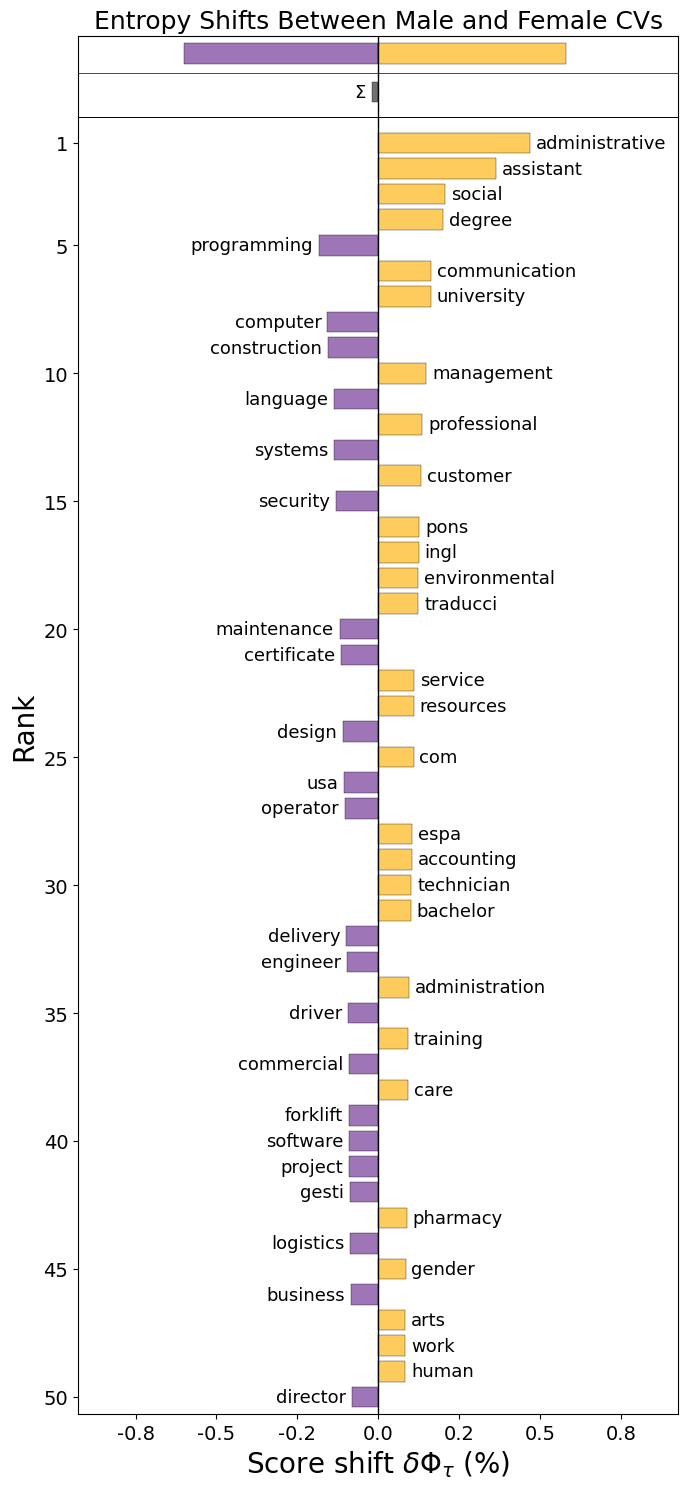


----- ENTROPY ANALYSIS EXPLANATION -----
What this graph shows:
- How words contribute to differences in language diversity and predictability
- Higher entropy indicates more diverse and unpredictable language use
- Lower entropy indicates more repetitive and predictable language patterns
- Bars to the right show words making the SECOND gender's language more diverse
- Bars to the left show words making the FIRST gender's language more diverse

Shannon entropy for Male CVs: 11.2279 bits
Shannon entropy for Female CVs: 11.0419 bits
Entropy difference: -0.1860 bits

Top entropy shift contributors: administrative (+0.0047), assistant (+0.0036), social (+0.0021), degree (+0.0020), programming (-0.0018)

Overall: Male CVs use more diverse and unpredictable language
This suggests Male candidates may:
- Use a broader vocabulary
- Present their experiences in more varied ways
- Have more diverse professional or educational backgrounds

Step 6: Analyzing KL divergence
Analyzing KL Divergence f

/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


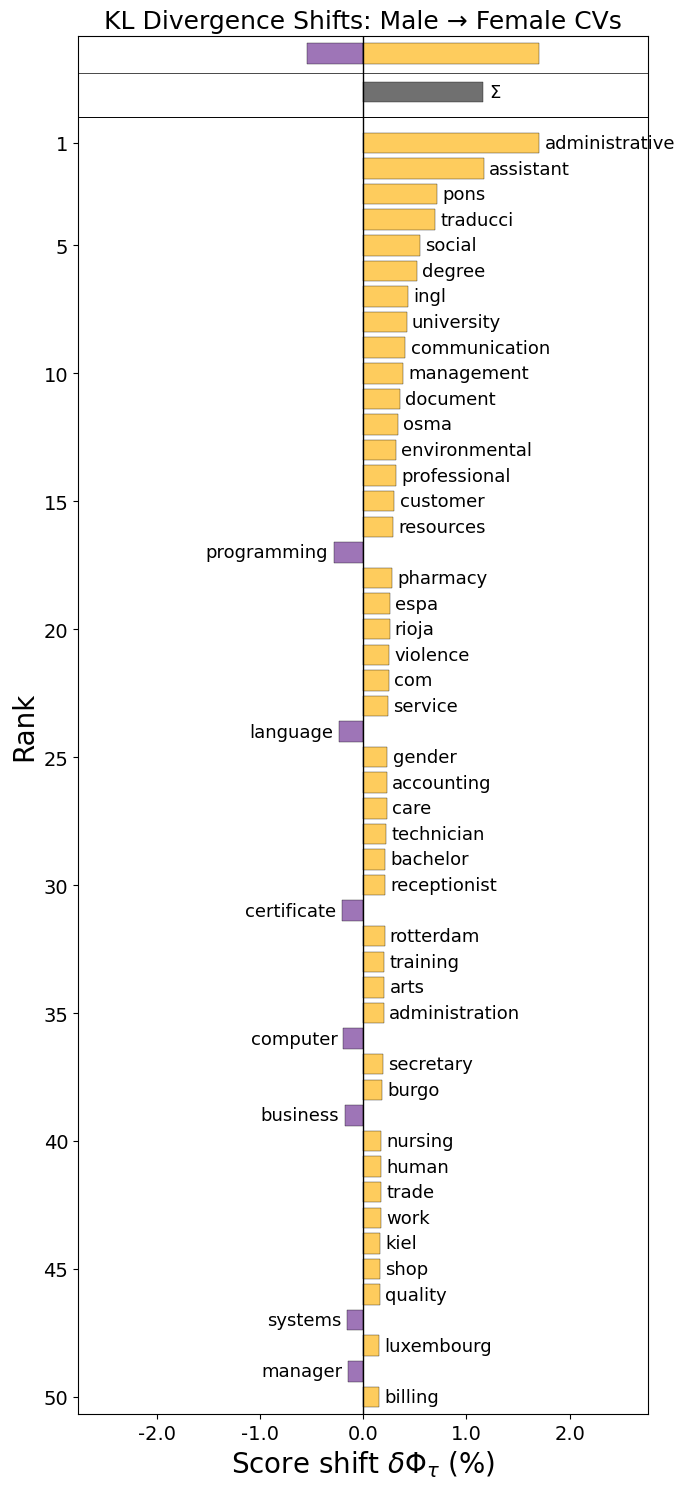


----- KL DIVERGENCE ANALYSIS EXPLANATION -----
What this graph shows:
- Information lost when approximating Male CV language with Female CV language
- KL Divergence measures asymmetric difference between probability distributions
- Higher values indicate greater linguistic dissimilarity
- This is a directional measure (Male→Female is different from Female→Male)

Total KL Divergence (Male→Female): 0.5177 bits
This means 0.5177 bits of information are lost on average when
representing Male CV language patterns using Female CV language patterns

Top contributors to KL divergence: administrative (+0.0170), assistant (+0.0117), pons (+0.0072), traducci (+0.0070), social (+0.0055)
These words create the most 'surprise' when expecting one gender's language
but encountering the other's

Analyzing KL Divergence from Female to Male CVs


/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


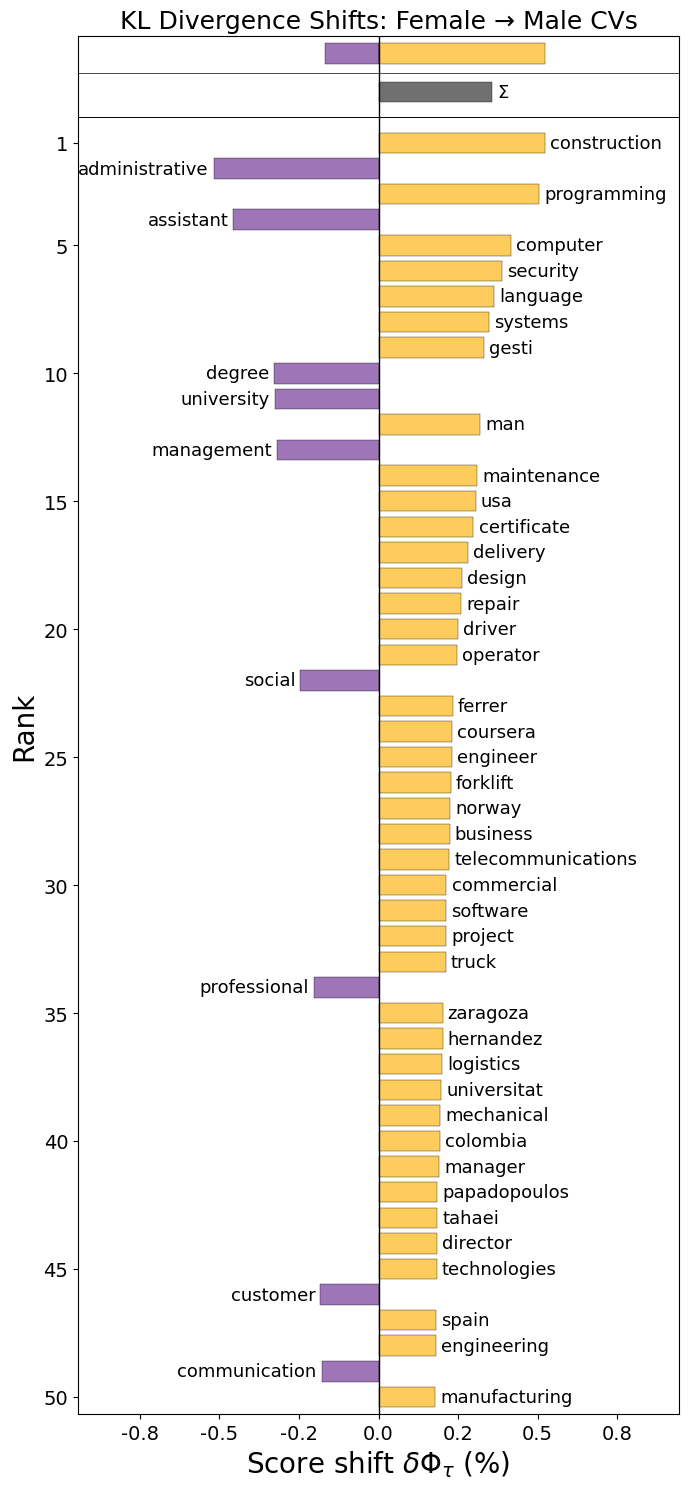


Total KL Divergence (Female→Male): 0.5146 bits

Comparing both directions:
- The language of Male CVs is MORE surprising when expecting Female patterns
- This suggests Male language may be more specialized or distinctive

What this suggests about gender differences:
- Words with high KL divergence represent gender-specific linguistic choices
- These may include industry-specific terms, educational credentials, or presentation styles
- The asymmetry in KL divergence highlights which gender's language is more specialized

Step 7: Analyzing word categories
Analyzing word categories between Male and Female CVs

----- WORD CATEGORY ANALYSIS EXPLANATION -----
What this analysis shows:
- How different genders emphasize various professional categories in their CVs
- Percentages represent how much of each gender's vocabulary falls into each category
- Differences highlight potential gender-based priorities or specializations

Category             | Male       | Female     | Difference
--------

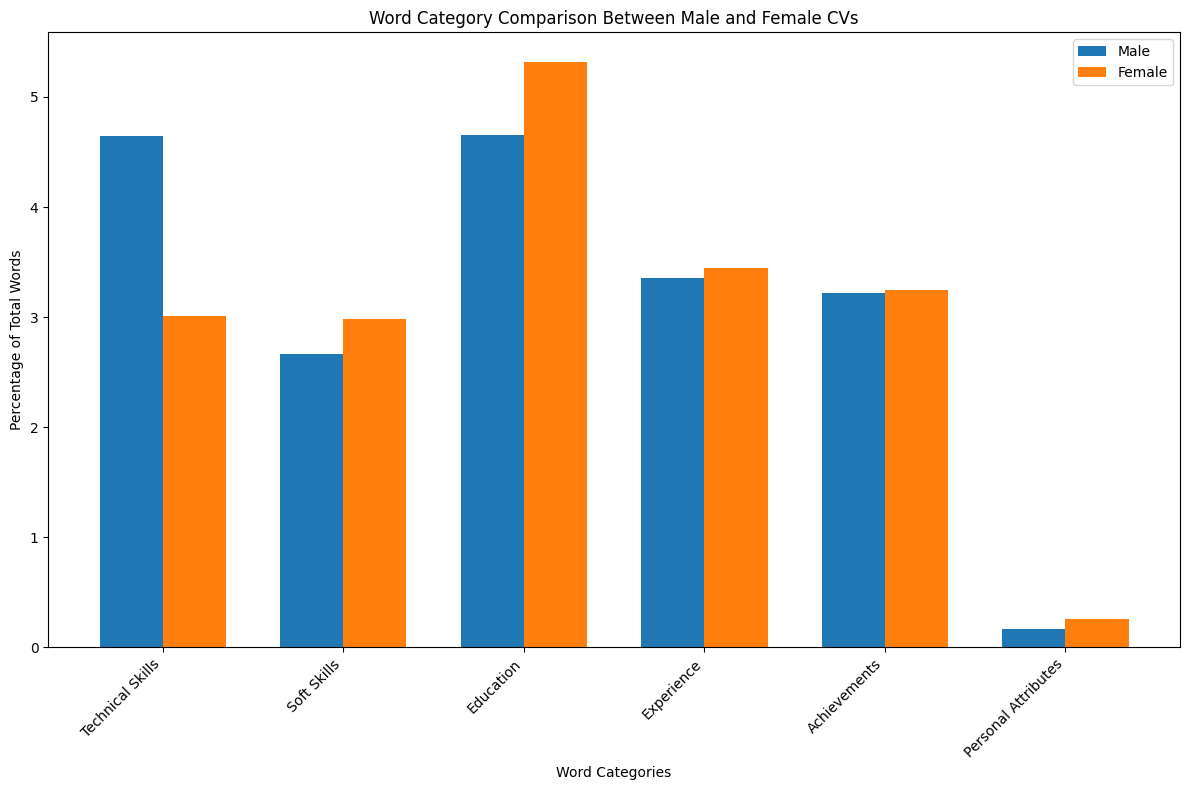


What this suggests about gender differences:
- Male CVs emphasize Technical Skills 1.64% more than Female CVs
- Female CVs emphasize Education 0.66% more than Male CVs
- Female CVs emphasize Soft Skills 0.31% more than Male CVs

These differences may reflect:
- Different professional roles and career paths between genders
- Different self-presentation strategies in professional contexts
- Potential gender-based expectations or socialization in the workplace

Key Insights from Gender Language Analysis:
Words more distinctive of Female CVs: administrative, assistant, degree, university, social, management, communication, professional, customer, technician
Words more distinctive of Male CVs: programming, computer, language, certificate, systems, construction, security, design, maintenance, business
No substantial difference in overall sentiment between genders

Entropy Analysis:
Male entropy: 11.2279 bits
Female entropy: 11.0419 bits
Male CVs use more diverse and unpredictable language



In [ ]:
# Shifterator Analysis - Gender Differences in CVs
import shifterator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import os
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords

# Fix collections.Mapping deprecation in Python 3.10+
import collections
import collections.abc
if not hasattr(collections, 'Mapping'):
    collections.Mapping = collections.abc.Mapping

# Download necessary NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# 1. Load the processed data with gender labels
# Assumes the previous cell has been run and we have gender_dataset available
# If not, we can load it from the saved CSV
GENDER_DATA_DIR = os.path.join(DATA_PATH, 'gender')
gender_dataset_path = os.path.join(GENDER_DATA_DIR, 'gender_dataset.csv')

if 'gender_dataset' not in globals():
    gender_dataset = pd.read_csv(gender_dataset_path)
    print(f"Loaded gender dataset from {gender_dataset_path}")

# 2. Group CV texts by gender
def prepare_text_by_gender(df, text_column='cv_text', gender_column='gender'):
    """Group and prepare text by gender category"""
    gender_texts = {}

    # Group texts by gender
    for gender in df[gender_column].unique():
        texts = df[df[gender_column] == gender][text_column].tolist()
        gender_texts[gender] = ' '.join(texts)

    return gender_texts

# 3. Create word frequency dictionaries for Shifterator
def create_word_freq_dicts(gender_texts, min_word_length=3, additional_stopwords=None):
    """
    Create word frequency dictionaries for each gender

    Parameters:
    -----------
    gender_texts : dict
        Keys are gender labels, values are combined text for each gender
    min_word_length : int
        Minimum word length to include
    additional_stopwords : list
        Additional stopwords to exclude beyond the NLTK English stopwords

    Returns:
    --------
    dict
        Keys are gender labels, values are dictionaries of word frequencies
    """

    gender_freq_dicts = {}
    stop_words = set(stopwords.words('english'))

    # Add custom stopwords common in CVs
    cv_stopwords = {'resume', 'cv', 'curriculum', 'vitae', 'email', 'phone',
                   'address', 'linkedin', 'github', 'http', 'https', 'www'}

    if additional_stopwords:
        cv_stopwords.update(additional_stopwords)

    stop_words.update(cv_stopwords)

    for gender, text in gender_texts.items():
        # Clean text: lowercase, remove non-alphabetic characters
        text = text.lower()
        text = re.sub(r'[^a-z\s]', ' ', text)

        # Tokenize
        words = word_tokenize(text)

        # Filter words: remove stopwords and short words
        words = [word for word in words
                if word not in stop_words and len(word) >= min_word_length]

        # Count frequencies
        word_counts = Counter(words)

        gender_freq_dicts[gender] = dict(word_counts)

    return gender_freq_dicts

# 4. Perform Shifterator analysis and visualize results
def analyze_gender_word_shifts(gender_freq_dicts, top_n=50, plot_title="Word Shifts Between Gender CV Texts"):
    """
    Analyze and visualize word shifts between genders

    Parameters:
    -----------
    gender_freq_dicts : dict
        Keys are gender labels, values are dictionaries of word frequencies
    top_n : int
        Number of top words to display in the shift graph
    plot_title : str
        Title for the shift graph
    """

    if len(gender_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 gender categories")

    genders = list(gender_freq_dicts.keys())
    gender1, gender2 = genders[0], genders[1]

    print(f"Analyzing word shifts between {gender1} and {gender2} CVs")

    # Create a simple shift (proportion shift)
    print("Creating proportion shift...")
    prop_shift = shifterator.shifts.ProportionShift(
        type2freq_1=gender_freq_dicts[gender1],
        type2freq_2=gender_freq_dicts[gender2]
    )

    # Create and display the shift graph
    print(f"Generating word shift graph for top {top_n} words...")
    ax = prop_shift.get_shift_graph(
        top_n=top_n,
        title=plot_title,
        cumulative_inset=False,
        text_size_inset=False,
        show_plot=True
    )

    # Print detailed explanation of proportion shift
    print("\n----- PROPORTION SHIFT EXPLANATION -----")
    print("What this graph shows:")
    print(f"- The words that are used with notably different frequencies between {gender1} and {gender2} CVs")
    print("- Bars extending right indicate words used MORE by the SECOND gender")
    print("- Bars extending left indicate words used MORE by the FIRST gender")
    print("- The length of each bar shows how much that word contributes to the overall difference")

    # Get top words for explanation
    shift_scores = prop_shift.get_shift_scores()
    sorted_words = sorted(shift_scores.items(), key=lambda x: x[1])
    top_gender2_words = [word for word, score in sorted_words[-5:]]
    top_gender1_words = [word for word, score in sorted_words[:5]]

    print(f"\nMost distinctive words for {genders[1]}: {', '.join(reversed(top_gender2_words))}")
    print(f"Most distinctive words for {genders[0]}: {', '.join(top_gender1_words)}")

    print("\nWhat this suggests:")
    print(f"- {genders[1]} CVs tend to emphasize: {', '.join(reversed(top_gender2_words))}")
    print(f"- {genders[0]} CVs tend to emphasize: {', '.join(top_gender1_words)}")
    print("- These differences may reflect gender-based variations in how people present their professional experiences")
    print("- They may also indicate differences in industry representation, roles, or educational backgrounds")

    # Create JSD shift for more detailed analysis
    print("\nCreating Jensen-Shannon Divergence shift...")
    jsd_shift = shifterator.shifts.JSDivergenceShift(
        type2freq_1=gender_freq_dicts[gender1],
        type2freq_2=gender_freq_dicts[gender2]
    )

    # Generate JSD shift graph
    print("Generating JSD word shift graph...")
    ax2 = jsd_shift.get_shift_graph(
        top_n=top_n,
        title=f"JSD Word Shifts Between {gender1} and {gender2} CVs",
        cumulative_inset=False,
        text_size_inset=False,
        show_plot=True
    )

    # Print detailed explanation of JSD shift
    print("\n----- JENSEN-SHANNON DIVERGENCE EXPLANATION -----")
    print("What this graph shows:")
    print("- Information-theoretic differences between gender groups' language patterns")
    print("- JSD measures how distinct two probability distributions are from each other")
    print("- Unlike proportion shift, JSD is sensitive to both common and rare words")
    print("- Words with high JSD contribution create 'surprise' when moving between language models")

    # Get top JSD words
    jsd_scores = jsd_shift.get_shift_scores()
    sorted_jsd_words = sorted(jsd_scores.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
    top_jsd_words = [word for word, _ in sorted_jsd_words]

    print(f"\nMost information-rich distinguishing words: {', '.join(top_jsd_words)}")
    print("\nWhat this suggests:")
    print("- These words create the most 'surprise' when reading CVs from one gender vs. another")
    print("- They represent meaningful differences in self-presentation between genders")
    print("- JSD-highlighted words may better represent genuine gender differences than simple frequency differences")

    return prop_shift, jsd_shift

# 5. Create sentiment analysis with a custom CV-specific lexicon
def analyze_sentiment_shifts(gender_freq_dicts, top_n=50):
    """
    Analyze sentiment differences between gender CV texts using a custom CV lexicon

    Parameters:
    -----------
    gender_freq_dicts : dict
        Keys are gender labels, values are dictionaries of word frequencies
    top_n : int
        Number of top words to display in the shift graph
    """

    if len(gender_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 gender categories")

    genders = list(gender_freq_dicts.keys())
    gender1, gender2 = genders[0], genders[1]

    print(f"Analyzing sentiment shifts between {gender1} and {gender2} CVs using custom CV lexicon")

    # Create a custom CV-specific sentiment lexicon
    # Values range from -1.0 (very negative) to 1.0 (very positive)
    cv_sentiment_lexicon = {
        # Positive professional terms
        'success': 0.9, 'excellent': 0.9, 'outstanding': 0.9, 'exceptional': 0.9,
        'achieved': 0.8, 'accomplished': 0.8, 'successful': 0.8, 'impressive': 0.8,
        'expert': 0.8, 'mastery': 0.8, 'proficient': 0.7, 'skilled': 0.7,
        'experienced': 0.7, 'qualified': 0.7, 'certified': 0.7, 'specialized': 0.7,
        'effectively': 0.7, 'efficiently': 0.7, 'productive': 0.7, 'quality': 0.7,
        'leader': 0.7, 'leadership': 0.7, 'award': 0.7, 'recognition': 0.7,
        'promoted': 0.7, 'advanced': 0.7, 'improved': 0.6, 'enhanced': 0.6,
        'innovative': 0.6, 'creative': 0.6, 'developed': 0.6, 'launched': 0.6,
        'exceeded': 0.6, 'surpassed': 0.6, 'goals': 0.5, 'objectives': 0.5,
        'team': 0.5, 'collaborate': 0.5, 'partnership': 0.5, 'committed': 0.5,
        'dedicated': 0.5, 'reliable': 0.5, 'responsible': 0.5, 'thorough': 0.5,
        'accurate': 0.5, 'professional': 0.5, 'ethical': 0.5, 'motivated': 0.5,
        'enthusiasm': 0.5, 'passion': 0.5, 'dynamic': 0.5, 'adaptable': 0.5,
        'flexible': 0.5, 'versatile': 0.5, 'multilingual': 0.5, 'bilingual': 0.5,

        # Neutral professional terms (0.0)
        'experience': 0.0, 'work': 0.0, 'job': 0.0, 'position': 0.0, 'role': 0.0,
        'responsibility': 0.0, 'duty': 0.0, 'task': 0.0, 'project': 0.0,
        'manage': 0.0, 'coordinate': 0.0, 'organize': 0.0, 'develop': 0.0,
        'implement': 0.0, 'analyze': 0.0, 'design': 0.0, 'create': 0.0,
        'university': 0.0, 'college': 0.0, 'degree': 0.0, 'education': 0.0,
        'bachelor': 0.0, 'master': 0.0, 'phd': 0.0, 'graduate': 0.0,
        'skills': 0.0, 'knowledge': 0.0, 'abilities': 0.0, 'competencies': 0.0,
        'company': 0.0, 'organization': 0.0, 'business': 0.0, 'industry': 0.0,
        'department': 0.0, 'sector': 0.0, 'field': 0.0, 'specialty': 0.0,

        # Negative professional terms
        'limited': -0.5, 'basic': -0.5, 'minimal': -0.5, 'entry': -0.3,
        'junior': -0.3, 'assistant': -0.3, 'intern': -0.3, 'novice': -0.5,
        'learning': -0.2, 'developing': -0.2, 'incomplete': -0.6, 'unfinished': -0.6,
        'discontinued': -0.7, 'terminated': -0.7, 'failed': -0.9, 'unsuccessful': -0.9,
        'mistake': -0.8, 'error': -0.8, 'problem': -0.6, 'difficulty': -0.6,
        'challenge': -0.4, 'challenging': -0.4, 'complex': -0.3, 'complicated': -0.3,
        'inexperienced': -0.7, 'unskilled': -0.7, 'untrained': -0.7, 'unfamiliar': -0.6,
        'gap': -0.5, 'deficit': -0.6, 'weakness': -0.6, 'poor': -0.8,
        'inadequate': -0.8, 'insufficient': -0.7, 'lacking': -0.7, 'deficient': -0.7
    }

    try:
        # Create weighted average shift with custom lexicon
        sentiment_shift = shifterator.shifts.WeightedAvgShift(
            type2freq_1=gender_freq_dicts[gender1],
            type2freq_2=gender_freq_dicts[gender2],
            type2score_1=cv_sentiment_lexicon,
            reference_value=0.0  # Use neutral as reference point
        )

        # Generate weighted average shift graph
        print("Generating sentiment shift graph...")
        ax = sentiment_shift.get_shift_graph(
            top_n=top_n,
            title=f"Sentiment Shifts Between {gender1} and {gender2} CVs",
            cumulative_inset=False,
            text_size_inset=False,
            show_plot=True
        )

        # Calculate average sentiment scores
        avg_score1 = sentiment_shift.get_weighted_score(
            gender_freq_dicts[gender1],
            cv_sentiment_lexicon
        )

        avg_score2 = sentiment_shift.get_weighted_score(
            gender_freq_dicts[gender2],
            cv_sentiment_lexicon
        )

        # Print detailed explanation
        print("\n----- SENTIMENT ANALYSIS EXPLANATION -----")
        print(f"Average sentiment score for {gender1} CVs: {avg_score1:.4f}")
        print(f"Average sentiment score for {gender2} CVs: {avg_score2:.4f}")
        print(f"Sentiment difference: {avg_score2 - avg_score1:+.4f}")

        print("\nWhat this sentiment shift graph shows:")
        print("- Words that contribute to sentiment differences between gender groups")
        print("- Bars extending right indicate words making the SECOND gender more positive")
        print("- Bars extending left indicate words making the FIRST gender more positive")
        print("- The color coding indicates whether a word is:")
        print("  * MORE frequent in one gender (purple/green)")
        print("  * Has a HIGHER/LOWER sentiment score (orange/blue)")

        if avg_score2 > avg_score1:
            print(f"\nOverall: {gender2} CVs use more positive professional language compared to {gender1} CVs.")
            print(f"This suggests {gender2} candidates may present their accomplishments in more positive terms.")
        elif avg_score1 > avg_score2:
            print(f"\nOverall: {gender1} CVs use more positive professional language compared to {gender2} CVs.")
            print(f"This suggests {gender1} candidates may present their accomplishments in more positive terms.")
        else:
            print("\nOverall: Both genders use similar levels of positive professional language.")

        return sentiment_shift, avg_score1, avg_score2

    except Exception as e:
        print(f"Sentiment analysis error: {str(e)}")
        print("Skipping sentiment analysis")
        return None, None, None

# 6. Add Entropy Shift Analysis
def analyze_entropy_shifts(gender_freq_dicts, top_n=50):
    """
    Analyze entropy differences between gender CV texts

    Parameters:
    -----------
    gender_freq_dicts : dict
        Keys are gender labels, values are dictionaries of word frequencies
    top_n : int
        Number of top words to display in the shift graph
    """

    if len(gender_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 gender categories")

    genders = list(gender_freq_dicts.keys())
    gender1, gender2 = genders[0], genders[1]

    print(f"Analyzing entropy shifts between {gender1} and {gender2} CVs")

    # Create entropy shift
    entropy_shift = shifterator.shifts.EntropyShift(
        type2freq_1=gender_freq_dicts[gender1],
        type2freq_2=gender_freq_dicts[gender2],
        base=2,  # Use base 2 for bits
        alpha=1.0  # Standard Shannon entropy
    )

    # Generate entropy shift graph
    print("Generating entropy shift graph...")
    ax = entropy_shift.get_shift_graph(
        top_n=top_n,
        title=f"Entropy Shifts Between {gender1} and {gender2} CVs",
        cumulative_inset=False,
        text_size_inset=False,
        show_plot=True
    )

    # Print overall entropy values
    type2freq_1 = gender_freq_dicts[gender1]
    type2freq_2 = gender_freq_dicts[gender2]

    # Calculate total frequencies
    total_1 = sum(type2freq_1.values())
    total_2 = sum(type2freq_2.values())

    # Create probability distributions
    prob_dist_1 = {word: count/total_1 for word, count in type2freq_1.items()}
    prob_dist_2 = {word: count/total_2 for word, count in type2freq_2.items()}

    # Calculate Shannon entropy
    from math import log2
    entropy_1 = -sum(p * log2(p) for p in prob_dist_1.values() if p > 0)
    entropy_2 = -sum(p * log2(p) for p in prob_dist_2.values() if p > 0)

    # Print detailed explanation
    print("\n----- ENTROPY ANALYSIS EXPLANATION -----")
    print("What this graph shows:")
    print("- How words contribute to differences in language diversity and predictability")
    print("- Higher entropy indicates more diverse and unpredictable language use")
    print("- Lower entropy indicates more repetitive and predictable language patterns")
    print("- Bars to the right show words making the SECOND gender's language more diverse")
    print("- Bars to the left show words making the FIRST gender's language more diverse")

    print(f"\nShannon entropy for {gender1} CVs: {entropy_1:.4f} bits")
    print(f"Shannon entropy for {gender2} CVs: {entropy_2:.4f} bits")
    print(f"Entropy difference: {entropy_2 - entropy_1:+.4f} bits")

    # Get top entropy contributors
    entropy_scores = entropy_shift.get_shift_scores()
    sorted_entropy = sorted(entropy_scores.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
    entropy_words = [f"{word} ({score:+.4f})" for word, score in sorted_entropy]

    print(f"\nTop entropy shift contributors: {', '.join(entropy_words)}")

    if entropy_1 > entropy_2:
        print(f"\nOverall: {gender1} CVs use more diverse and unpredictable language")
        print(f"This suggests {gender1} candidates may:")
        print("- Use a broader vocabulary")
        print("- Present their experiences in more varied ways")
        print("- Have more diverse professional or educational backgrounds")
    elif entropy_2 > entropy_1:
        print(f"\nOverall: {gender2} CVs use more diverse and unpredictable language")
        print(f"This suggests {gender2} candidates may:")
        print("- Use a broader vocabulary")
        print("- Present their experiences in more varied ways")
        print("- Have more diverse professional or educational backgrounds")
    else:
        print("\nOverall: Both genders use similarly diverse language")

    return entropy_shift, entropy_1, entropy_2

# 7. Add KL Divergence Analysis
def analyze_kl_divergence(gender_freq_dicts, top_n=50):
    """
    Analyze KL Divergence between gender CV texts

    Parameters:
    -----------
    gender_freq_dicts : dict
        Keys are gender labels, values are dictionaries of word frequencies
    top_n : int
        Number of top words to display in the shift graph
    """

    if len(gender_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 gender categories")

    genders = list(gender_freq_dicts.keys())
    gender1, gender2 = genders[0], genders[1]

    print(f"Analyzing KL Divergence from {gender1} to {gender2} CVs")

    # Need to ensure all words appear in both distributions for KL divergence
    all_words = set(gender_freq_dicts[gender1].keys()) | set(gender_freq_dicts[gender2].keys())

    # Create modified frequency dictionaries with all words
    mod_freq_1 = gender_freq_dicts[gender1].copy()
    mod_freq_2 = gender_freq_dicts[gender2].copy()

    # Add smoothing for words that don't appear in one corpus
    for word in all_words:
        if word not in mod_freq_1:
            mod_freq_1[word] = 1  # Laplace smoothing
        if word not in mod_freq_2:
            mod_freq_2[word] = 1  # Laplace smoothing

    try:
        # Create KL divergence shift
        kl_shift = shifterator.shifts.KLDivergenceShift(
            type2freq_1=mod_freq_1,
            type2freq_2=mod_freq_2,
            base=2  # Use base 2 for bits
        )

        # Generate KL divergence shift graph
        print("Generating KL divergence shift graph...")
        ax = kl_shift.get_shift_graph(
            top_n=top_n,
            title=f"KL Divergence Shifts: {gender1} → {gender2} CVs",
            cumulative_inset=False,
            text_size_inset=False,
            show_plot=True
        )

        # Calculate total KL divergence
        kl_scores = kl_shift.get_shift_scores()
        total_kl_div = sum(kl_scores.values())

        # Print detailed explanation
        print("\n----- KL DIVERGENCE ANALYSIS EXPLANATION -----")
        print("What this graph shows:")
        print(f"- Information lost when approximating {gender1} CV language with {gender2} CV language")
        print("- KL Divergence measures asymmetric difference between probability distributions")
        print("- Higher values indicate greater linguistic dissimilarity")
        print("- This is a directional measure (Male→Female is different from Female→Male)")

        print(f"\nTotal KL Divergence ({gender1}→{gender2}): {total_kl_div:.4f} bits")
        print(f"This means {total_kl_div:.4f} bits of information are lost on average when")
        print(f"representing {gender1} CV language patterns using {gender2} CV language patterns")

        # Get top KL contributors
        sorted_kl = sorted(kl_scores.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
        kl_words = [f"{word} ({score:+.4f})" for word, score in sorted_kl]

        print(f"\nTop contributors to KL divergence: {', '.join(kl_words)}")
        print("These words create the most 'surprise' when expecting one gender's language")
        print("but encountering the other's")

        # Also try reverse direction
        print(f"\nAnalyzing KL Divergence from {gender2} to {gender1} CVs")
        kl_shift_reverse = shifterator.shifts.KLDivergenceShift(
            type2freq_1=mod_freq_2,
            type2freq_2=mod_freq_1,
            base=2  # Use base 2 for bits
        )

        ax2 = kl_shift_reverse.get_shift_graph(
            top_n=top_n,
            title=f"KL Divergence Shifts: {gender2} → {gender1} CVs",
            cumulative_inset=False,
            text_size_inset=False,
            show_plot=True
        )

        # Calculate total reverse KL divergence
        kl_scores_rev = kl_shift_reverse.get_shift_scores()
        total_kl_div_rev = sum(kl_scores_rev.values())

        print(f"\nTotal KL Divergence ({gender2}→{gender1}): {total_kl_div_rev:.4f} bits")

        # Compare the two directions
        print("\nComparing both directions:")
        if total_kl_div > total_kl_div_rev:
            print(f"- The language of {gender1} CVs is MORE surprising when expecting {gender2} patterns")
            print(f"- This suggests {gender1} language may be more specialized or distinctive")
        elif total_kl_div < total_kl_div_rev:
            print(f"- The language of {gender2} CVs is MORE surprising when expecting {gender1} patterns")
            print(f"- This suggests {gender2} language may be more specialized or distinctive")
        else:
            print("- Both directions show similar levels of surprise")

        print("\nWhat this suggests about gender differences:")
        print("- Words with high KL divergence represent gender-specific linguistic choices")
        print("- These may include industry-specific terms, educational credentials, or presentation styles")
        print("- The asymmetry in KL divergence highlights which gender's language is more specialized")

        return kl_shift, kl_shift_reverse

    except Exception as e:
        print(f"KL Divergence analysis error: {str(e)}")
        return None, None

# 8. Word Category Analysis
def analyze_word_categories(gender_freq_dicts):
    """
    Analyze differences in word categories between gender CV texts

    Parameters:
    -----------
    gender_freq_dicts : dict
        Keys are gender labels, values are dictionaries of word frequencies
    """

    if len(gender_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 gender categories")

    genders = list(gender_freq_dicts.keys())
    gender1, gender2 = genders[0], genders[1]

    print(f"Analyzing word categories between {gender1} and {gender2} CVs")

    # Define word categories relevant to CVs
    categories = {
        'technical_skills': [
            'programming', 'software', 'hardware', 'database', 'network', 'system',
            'code', 'develop', 'algorithm', 'analysis', 'technical', 'computer',
            'engineering', 'design', 'implement', 'technology', 'architecture'
        ],
        'soft_skills': [
            'communication', 'leadership', 'teamwork', 'collaboration', 'interpersonal',
            'organize', 'manage', 'coordinate', 'facilitate', 'negotiate', 'present',
            'adaptable', 'flexible', 'creative', 'innovative', 'problem-solving'
        ],
        'education': [
            'university', 'college', 'degree', 'bachelor', 'master', 'phd', 'doctorate',
            'thesis', 'dissertation', 'graduate', 'academic', 'study', 'education',
            'major', 'minor', 'certificate', 'diploma', 'school', 'gpa'
        ],
        'experience': [
            'experience', 'job', 'work', 'position', 'role', 'career', 'professional',
            'industry', 'company', 'business', 'corporate', 'employer', 'supervisor',
            'employee', 'employment', 'responsibility', 'task', 'duty'
        ],
        'achievements': [
            'achieve', 'success', 'award', 'recognition', 'honor', 'accomplish',
            'improve', 'increase', 'decrease', 'optimize', 'enhance', 'develop',
            'create', 'implement', 'launch', 'lead', 'manage', 'direct', 'supervise'
        ],
        'personal_attributes': [
            'detail-oriented', 'meticulous', 'thorough', 'efficient', 'effective',
            'reliable', 'dependable', 'trustworthy', 'honest', 'ethical', 'moral',
            'hardworking', 'dedicated', 'committed', 'passionate', 'enthusiastic'
        ]
    }

    # Calculate category scores for each gender
    category_scores = {}

    for category, words in categories.items():
        category_scores[category] = {}

        for gender, freq_dict in gender_freq_dicts.items():
            # Get total word count for this gender
            total_words = sum(freq_dict.values())

            # Count words in this category
            category_count = 0
            for word in words:
                # Match partial words (e.g., "program" would match "programming", "programmer", etc.)
                for cv_word, count in freq_dict.items():
                    if word in cv_word:
                        category_count += count

            # Calculate percentage
            category_scores[category][gender] = (category_count / total_words) * 100

    # Print and visualize results
    print("\n----- WORD CATEGORY ANALYSIS EXPLANATION -----")
    print("What this analysis shows:")
    print("- How different genders emphasize various professional categories in their CVs")
    print("- Percentages represent how much of each gender's vocabulary falls into each category")
    print("- Differences highlight potential gender-based priorities or specializations")

    # Create lists for plotting
    categories_list = list(categories.keys())
    gender1_scores = [category_scores[cat][gender1] for cat in categories_list]
    gender2_scores = [category_scores[cat][gender2] for cat in categories_list]

    # Print table of results
    print(f"\n{'Category':<20} | {gender1:<10} | {gender2:<10} | Difference")
    print("-" * 60)

    for i, category in enumerate(categories_list):
        diff = gender2_scores[i] - gender1_scores[i]
        print(f"{category.replace('_', ' ').title():<20} | {gender1_scores[i]:>8.2f}% | {gender2_scores[i]:>8.2f}% | {diff:>+8.2f}%")

    # Create bar chart
    plt.figure(figsize=(12, 8))

    x = range(len(categories_list))
    width = 0.35

    plt.bar([i - width/2 for i in x], gender1_scores, width=width, label=gender1)
    plt.bar([i + width/2 for i in x], gender2_scores, width=width, label=gender2)

    plt.xlabel('Word Categories')
    plt.ylabel('Percentage of Total Words')
    plt.title(f'Word Category Comparison Between {gender1} and {gender2} CVs')

    plt.xticks(x, [c.replace('_', ' ').title() for c in categories_list], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Provide interpretation
    print("\nWhat this suggests about gender differences:")

    # Find largest differences (positive and negative)
    diffs = [(cat, gender2_scores[i] - gender1_scores[i]) for i, cat in enumerate(categories_list)]
    sorted_diffs = sorted(diffs, key=lambda x: abs(x[1]), reverse=True)

    for cat, diff in sorted_diffs[:3]:  # Top 3 differences
        cat_display = cat.replace('_', ' ').title()
        if diff > 0:
            print(f"- {gender2} CVs emphasize {cat_display} {diff:.2f}% more than {gender1} CVs")
        else:
            print(f"- {gender1} CVs emphasize {cat_display} {-diff:.2f}% more than {gender2} CVs")

    # Overall interpretation
    print("\nThese differences may reflect:")
    print("- Different professional roles and career paths between genders")
    print("- Different self-presentation strategies in professional contexts")
    print("- Potential gender-based expectations or socialization in the workplace")

    return category_scores

# 9. Main analysis function
def run_gender_language_analysis(df, text_column='cv_text', gender_column='gender'):
    """
    Run the complete gender language analysis pipeline
    """
    print("\nPerforming Gender Language Analysis with Shifterator")
    print("----------------------------------------------------")

    # Prepare texts by gender
    print("\nStep 1: Preparing texts by gender")
    gender_texts = prepare_text_by_gender(df, text_column, gender_column)

    # Generate word frequency dictionaries
    print("\nStep 2: Creating word frequency dictionaries")
    gender_freq_dicts = create_word_freq_dicts(gender_texts)

    # Get vocabulary statistics
    print("\nVocabulary Statistics:")
    for gender, freq_dict in gender_freq_dicts.items():
        total_words = sum(freq_dict.values())
        unique_words = len(freq_dict)
        print(f"{gender} CVs: {total_words} total words, {unique_words} unique words")

    # Analyze word proportion shifts
    print("\nStep 3: Analyzing word proportion shifts")
    prop_shift, jsd_shift = analyze_gender_word_shifts(gender_freq_dicts)

    # Analyze sentiment shifts
    print("\nStep 4: Analyzing sentiment shifts")
    try:
        sentiment_shift, avg_score1, avg_score2 = analyze_sentiment_shifts(gender_freq_dicts)
        sentiment_analysis_successful = sentiment_shift is not None
    except Exception as e:
        print(f"Sentiment analysis error: {str(e)}")
        print("Skipping sentiment analysis")
        sentiment_analysis_successful = False

    # Analyze entropy shifts
    print("\nStep 5: Analyzing entropy shifts")
    try:
        entropy_shift, entropy1, entropy2 = analyze_entropy_shifts(gender_freq_dicts)
        entropy_analysis_successful = True
    except Exception as e:
        print(f"Entropy analysis error: {str(e)}")
        print("Skipping entropy analysis")
        entropy_analysis_successful = False

    # Analyze KL divergence
    print("\nStep 6: Analyzing KL divergence")
    try:
        kl_shift, kl_shift_reverse = analyze_kl_divergence(gender_freq_dicts)
        kl_analysis_successful = kl_shift is not None
    except Exception as e:
        print(f"KL divergence analysis error: {str(e)}")
        print("Skipping KL divergence analysis")
        kl_analysis_successful = False

    # Analyze word categories
    print("\nStep 7: Analyzing word categories")
    try:
        category_scores = analyze_word_categories(gender_freq_dicts)
        category_analysis_successful = True
    except Exception as e:
        print(f"Word category analysis error: {str(e)}")
        print("Skipping word category analysis")
        category_analysis_successful = False

    # Generate interpretable insights
    print("\nKey Insights from Gender Language Analysis:")
    genders = list(gender_freq_dicts.keys())

    # Get top distinctive words for each gender
    shift_scores = prop_shift.get_shift_scores()
    sorted_words = sorted(shift_scores.items(), key=lambda x: x[1])

    # Words more common in gender 2
    top_gender2_words = [word for word, score in sorted_words[-10:]]
    # Words more common in gender 1
    top_gender1_words = [word for word, score in sorted_words[:10]]

    print(f"Words more distinctive of {genders[1]} CVs: {', '.join(reversed(top_gender2_words))}")
    print(f"Words more distinctive of {genders[0]} CVs: {', '.join(top_gender1_words)}")

    if sentiment_analysis_successful:
        sentiment_diff = avg_score2 - avg_score1
        if abs(sentiment_diff) > 0.1:  # Threshold for meaningful difference
            higher_gender = genders[1] if sentiment_diff > 0 else genders[0]
            print(f"{higher_gender} CVs use more positive language overall")
        else:
            print("No substantial difference in overall sentiment between genders")

    if entropy_analysis_successful:
        print(f"\nEntropy Analysis:")
        print(f"{genders[0]} entropy: {entropy1:.4f} bits")
        print(f"{genders[1]} entropy: {entropy2:.4f} bits")
        higher_entropy = genders[0] if entropy1 > entropy2 else genders[1]
        print(f"{higher_entropy} CVs use more diverse and unpredictable language")

    if category_analysis_successful:
        print("\nCategory Analysis Highlights:")
        # Find most distinctive categories
        for category, scores in category_scores.items():
            diff = scores[genders[1]] - scores[genders[0]]
            if abs(diff) > 1.0:  # Only report substantial differences
                if diff > 0:
                    print(f"- {genders[1]} CVs use {diff:.1f}% more {category.replace('_', ' ')} terms")
                else:
                    print(f"- {genders[0]} CVs use {-diff:.1f}% more {category.replace('_', ' ')} terms")

    print("\nShifterator gender analysis complete!")

    return {
        'gender_texts': gender_texts,
        'gender_freq_dicts': gender_freq_dicts,
        'proportion_shift': prop_shift,
        'jsd_shift': jsd_shift,
        'sentiment_shift': sentiment_shift if sentiment_analysis_successful else None,
        'entropy_shift': entropy_shift if entropy_analysis_successful else None,
        'kl_shift': kl_shift if kl_analysis_successful else None,
        'category_scores': category_scores if category_analysis_successful else None
    }

# Execute the analysis if the data is available
if 'gender_dataset' in globals() and len(gender_dataset) > 0:
    results = run_gender_language_analysis(gender_dataset)
else:
    print("Gender dataset not available. Please run the previous cell first to prepare the dataset.")

In [ ]:
def delete_ethnicity_files():
    """
    Delete ethnicity classification files to force rebuilding them.
    Run this function in a separate cell before running the main code.
    """
    import os
    from google.colab import drive

    # Mount drive if not already mounted
    try:
        drive.mount('/content/drive')
    except:
        print("Drive already mounted or couldn't be mounted")

    # Set paths (same as in your main code)
    PROJECT_ROOT = '/content/drive/MyDrive/anonymised_CVs_classification'
    DATA_PATH = os.path.join(PROJECT_ROOT, 'data')
    ETHNICITY_DATA_DIR = os.path.join(DATA_PATH, 'ethnicity')

    # Files to delete
    files_to_delete = [
        os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_raw.csv'),
        os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_dataset.csv'),
        os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_train.csv'),
        os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_val.csv'),
        os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_test.csv')
    ]

    # Delete each file if it exists
    deleted_count = 0
    for file_path in files_to_delete:
        if os.path.exists(file_path):
            try:
                os.remove(file_path)
                print(f"Deleted: {file_path}")
                deleted_count += 1
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")

    print(f"Deleted {deleted_count} ethnicity-related files. The next run will rebuild these files.")

# Example usage:
delete_ethnicity_files()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Deleted: /content/drive/MyDrive/anonymised_CVs_classification/data/ethnicity/ethnicity_raw.csv
Deleted: /content/drive/MyDrive/anonymised_CVs_classification/data/ethnicity/ethnicity_dataset.csv
Deleted: /content/drive/MyDrive/anonymised_CVs_classification/data/ethnicity/ethnicity_train.csv
Deleted: /content/drive/MyDrive/anonymised_CVs_classification/data/ethnicity/ethnicity_val.csv
Deleted: /content/drive/MyDrive/anonymised_CVs_classification/data/ethnicity/ethnicity_test.csv
Deleted 5 ethnicity-related files. The next run will rebuild these files.


In [ ]:
"""
Process real ethnicity data from CV submissions using enhanced classifier
"""

from google.colab import drive
import sys
import os
import pandas as pd
import json
import time
from typing import Dict, Optional

# Mount Drive
drive.mount('/content/drive')

# Set paths based on your structure
PROJECT_ROOT = '/content/drive/MyDrive/anonymised_CVs_classification'
MODULE_PATH = os.path.join(PROJECT_ROOT, 'modules')
CONFIG_PATH = os.path.join(PROJECT_ROOT, 'attribute_configs')
DATA_PATH = os.path.join(PROJECT_ROOT, 'data')
ETHNICITY_DATA_DIR = os.path.join(DATA_PATH, 'ethnicity')
RAW_DATA_PATH = '/content/drive/MyDrive/submissions'

# Create directories if they don't exist
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(ETHNICITY_DATA_DIR, exist_ok=True)

# Add paths to sys.path for importing
sys.path.append(MODULE_PATH)
sys.path.append(CONFIG_PATH)

# Import needed modules
import data_utils
from attribute_configs.ethnicity_config import ATTRIBUTE_MAPPINGS, process_ethnicity

def main():
    print("Starting ethnicity data processing...")

    # Step 1: Check if we have the base dataset
    base_data_path = os.path.join(DATA_PATH, 'base_data.csv')

    # if os.path.exists(base_data_path):
    #     print(f"Loading existing base dataset from {base_data_path}")
    #     base_df = pd.read_csv(base_data_path)
    if True: #it was else
        print("Creating base dataset...")

        # Organize files by person
        person_directories = data_utils.organize_files_by_person(RAW_DATA_PATH)

        # Match files
        matched_pairs, unmatched_raw_files = data_utils.match_files_by_person(person_directories)

        # Create dataset from matched pairs
        base_df = data_utils.create_dataset_from_pairs(matched_pairs)

        # Save base dataset
        base_df.to_csv(base_data_path, index=False)

    print(f"Base dataset has {len(base_df)} records")

    # Step 2: Extract ethnicity data
    ethnicity_raw_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_raw.csv')

    if os.path.exists(ethnicity_raw_path):
        # We can load existing ethnicity data to analyze distribution
        print(f"Loading existing ethnicity data from {ethnicity_raw_path}")
        ethnicity_df = pd.read_csv(ethnicity_raw_path)

        # Check if we need to reprocess the data with the new Null category
        if "Null" not in ethnicity_df['select-9_mapped'].unique():
            print("Reprocessing data to add Null category...")
            # Reprocess to differentiate between Null and Unknown
            for idx, row in ethnicity_df.iterrows():
                if row['select-9_mapped'] == "Unknown":
                    value = row['select-9_value']
                    if not value or not isinstance(value, str) or value.strip() == "":
                        ethnicity_df.at[idx, 'select-9_mapped'] = "Null"
            # Save updated ethnicity data
            ethnicity_df.to_csv(ethnicity_raw_path, index=False)

        analyze_distribution = True
    else:
        print("Extracting ethnicity data with advanced processing...")

        # Modified extract_attribute_from_raw to track advanced mapping
        ethnicity_df = base_df.copy()
        ethnicity_df['select-9_value'] = None
        ethnicity_df['select-9_mapped'] = None

        # Track statistics
        processed_count = 0
        null_count = 0       # Count of null/empty entries
        exact_match_count = 0
        advanced_mapped_count = 0
        unmapped_count = 0
        unmapped_values = {}

        start_time = time.time()

        for idx, row in base_df.iterrows():
            if idx % 100 == 0 and idx > 0:
                elapsed = time.time() - start_time
                print(f"Processed {idx} records in {elapsed:.2f} seconds ({idx/elapsed:.2f} records/sec)")

            try:
                # Load the raw JSON data
                with open(row['raw_file'], 'r', encoding='utf-8') as f:
                    raw_data = json.load(f)

                # Extract the ethnicity
                ethnicity_value = None
                if 'meta_data' in raw_data and 'select-9' in raw_data['meta_data']:
                    if isinstance(raw_data['meta_data']['select-9'], dict) and 'value' in raw_data['meta_data']['select-9']:
                        ethnicity_value = raw_data['meta_data']['select-9']['value']

                # Store the raw value
                ethnicity_df.at[idx, 'select-9_value'] = ethnicity_value

                # Map the value using the modified process_ethnicity function
                mapped_value = None

                if ethnicity_value is not None:
                    if ethnicity_value in ATTRIBUTE_MAPPINGS:
                        mapped_value = ATTRIBUTE_MAPPINGS[ethnicity_value]
                        exact_match_count += 1
                    else:
                        # Use advanced mapping
                        mapped_value = process_ethnicity(ethnicity_value)

                        if mapped_value == "Null":
                            null_count += 1
                        elif mapped_value == "Unknown":
                            unmapped_count += 1
                            if ethnicity_value not in unmapped_values:
                                unmapped_values[ethnicity_value] = 0
                            unmapped_values[ethnicity_value] += 1
                        else:
                            advanced_mapped_count += 1
                else:
                    # If ethnicity_value is None, set as Null
                    mapped_value = "Null"
                    null_count += 1

                # Store the mapped value
                ethnicity_df.at[idx, 'select-9_mapped'] = mapped_value

            except Exception as e:
                print(f"Error processing record {idx}: {e}")
                ethnicity_df.at[idx, 'select-9_mapped'] = "Unknown"

        # Report statistics
        print(f"\nProcessing Statistics:")
        print(f"  Exact matches: {exact_match_count}")
        print(f"  Advanced mapping matches: {advanced_mapped_count}")
        print(f"  Null/empty values: {null_count}")
        print(f"  Failed classifications: {unmapped_count}")

        # Save ethnicity data
        ethnicity_df.to_csv(ethnicity_raw_path, index=False)
        analyze_distribution = True

    # Analyze distribution if we have the data
    if analyze_distribution:
        print("\nEthnicity Distribution:")
        distribution = ethnicity_df['select-9_mapped'].value_counts()
        total = distribution.sum()

        print("Category      Count    Percentage")
        print("---------------------------------")
        for category, count in distribution.items():
            percentage = count / total * 100
            print(f"{category:<12} {count:6d}    {percentage:6.2f}%")

        # If we have unmapped values and they're in a dictionary (new processing), show them
        if 'unmapped_values' in locals() and len(unmapped_values) > 0:
            print("\nMost Common Values That Failed Classification:")
            sorted_unmapped = sorted(unmapped_values.items(), key=lambda x: x[1], reverse=True)
            for value, count in sorted_unmapped[:10]:  # Show top 10
                print(f"  '{value}': {count} occurrences")

    # Step 3: Generate full ethnicity dataset with CV text
    ethnicity_dataset_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_dataset.csv')

    if os.path.exists(ethnicity_dataset_path):
        print(f"\nEthnicity dataset already exists at {ethnicity_dataset_path}")
    else:
        print("\nGenerating ethnicity dataset with CV text...")
        ethnicity_dataset = data_utils.generate_attribute_dataset(
            ethnicity_df,
            attribute_field='select-9_mapped',
            attribute_name='Ethnicity',
            attribute_column='ethnicity',
            output_csv_path=ethnicity_dataset_path
        )

    # Step 4: Create train/val/test splits if needed
    splits_exist = all(os.path.exists(os.path.join(ETHNICITY_DATA_DIR, f"ethnicity_{split}.csv"))
                      for split in ['train', 'val', 'test'])

    if not splits_exist:
        print("\nCreating train/val/test splits...")
        ethnicity_dataset = pd.read_csv(ethnicity_dataset_path)

        # Only include records with Majority, Minority, or Both
        valid_categories = ['Majority', 'Minority', 'Both']
        ethnicity_dataset = ethnicity_dataset[ethnicity_dataset['ethnicity'].isin(valid_categories)]

        data_utils.create_train_val_test_split(
            ethnicity_dataset,
            target_column='ethnicity',
            output_dir=ETHNICITY_DATA_DIR,
            prefix='ethnicity'
        )
    else:
        print("\nTrain/val/test splits already exist")

    print("\nEthnicity data processing completed! Ready for model training.")

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting ethnicity data processing...
Creating base dataset...
Found 1143 person directories
Found 1142 raw JSON files across all person directories
Found 933 anonymized-parsed JSON files across all person directories

Sample person directories:
Person: 723_494_es
  Raw files: ['raw-723.json']
  Parsed files: ['secondary_cv-723-en-anonymized-edenai.json']
Person: 705_494_es
  Raw files: ['raw-705.json']
  Parsed files: ['secondary_cv-705-en-anonymized-edenai.json']
Person: 910_494_es
  Raw files: ['raw-910.json']
  Parsed files: ['main_cv-910-en-anonymized-edenai.json']
Matched 921 pairs out of 1142 raw files
Used 921 unique parsed files
Unmatched raw files: 221
Base dataset has 921 records
Extracting ethnicity data with advanced processing...
Processed 100 records in 0.34 seconds (294.73 records/sec)
Processed 200 records in 0.62 seconds (324.27 records/sec)

# Ethnicity Prediction Summary  
**Content**: Configures a Colab/local environment for binary ethnicity classification from CV text, comparing DistilBERT, RoBERTa, and mBERT. Includes automatic GPU detection, data preprocessing (cleaning, tokenization), and model training with dropout, gradient clipping, and early stopping.  
**Process**: Loads pre-split data (564 train/71 val/71 test samples), applies CV-specific text cleaning, and trains models with cosine LR scheduling. Handles CPU/GPU compatibility and model patching for label mismatches.  
**Results**: All models achieved identical performance (69.0% accuracy, 0.564 F1), with DistilBERT recommended for efficiency. Warning indicates potential class imbalance (all predictions for one class in confusion matrix: [[49,0],[22,0]]).

In [ ]:
"""
Train and evaluate binary ethnicity prediction model comparing DistilBERT, RoBERTa, and mBERT
Modified to work on both Colab and local environments (VS Code)
"""

import sys
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
import time
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    BertTokenizer, BertForSequenceClassification,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from torch.optim import AdamW
import numpy as np
from tqdm import tqdm

# --------------------------------------
# Check environment and setup accordingly
# --------------------------------------
def is_colab_environment():
    """Check if the code is running in Google Colab"""
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Setup paths based on environment
if is_colab_environment():
    from google.colab import drive
    drive.mount('/content/drive')
    # Handle space in "My Drive" and add project root to Python path
    PROJECT_ROOT = '/content/drive/MyDrive/anonymised_CVs_classification'
else:
    # Local environment paths - UPDATE THESE FOR YOUR LOCAL SETUP
    PROJECT_ROOT = os.path.abspath(os.path.dirname(__file__))  # Current directory

# Set paths based on your structure
MODULE_PATH = os.path.join(PROJECT_ROOT, 'modules')
CONFIG_PATH = os.path.join(PROJECT_ROOT, 'attribute_configs')
DATA_PATH = os.path.join(PROJECT_ROOT, 'data')
ETHNICITY_DATA_DIR = os.path.join(DATA_PATH, 'ethnicity')
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models', 'ethnicity')

# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(os.path.join(MODEL_DIR, 'plots'), exist_ok=True)
os.makedirs(ETHNICITY_DATA_DIR, exist_ok=True)

# For local environment, create necessary directories and files
if not is_colab_environment():
    # Create module directories if they don't exist
    os.makedirs(MODULE_PATH, exist_ok=True)
    os.makedirs(CONFIG_PATH, exist_ok=True)

    # Create __init__.py files if they don't exist
    for path in [os.path.join(MODULE_PATH, '__init__.py'),
                 os.path.join(CONFIG_PATH, '__init__.py')]:
        if not os.path.exists(path):
            with open(path, 'w') as f:
                pass  # Create empty file

# Add paths to sys.path for importing
sys.path.append(MODULE_PATH)
sys.path.append(CONFIG_PATH)
sys.path.append(PROJECT_ROOT)

# Device Configuration
def get_device_with_warning():
    """Get the appropriate device (GPU or CPU) and provide warning if necessary"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("GPU is available! Using CUDA.")
    else:
        device = torch.device('cpu')
        print("WARNING: GPU is not available. Using CPU instead which will be much slower for training.")
        print("Consider using Google Colab with GPU runtime for faster training.")

    return device

# Get device
device = get_device_with_warning()

# Import needed modules
try:
    import text_utils
    import model_utils
    import viz_utils
    from attribute_configs.ethnicity_config import BATCH_SIZE, NUM_EPOCHS
except ImportError as e:
    print(f"Error importing modules: {e}")
    print("Make sure your project structure is correct.")
    print(f"PROJECT_ROOT is set to: {PROJECT_ROOT}")
    print("You may need to create/update the modules and attribute_configs packages.")
    # Continue anyway as we'll provide fallback code

# --------------------------------------
# Add patching solution to fix label/labels mismatch
# --------------------------------------
def fix_dataset_mismatch():
    # Define a patched version of the CVDataset class
    class PatchedCVDataset(torch.utils.data.Dataset):
        def __init__(self, df, tokenizer, max_length=512):
            self.df = df
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            text = str(self.df.iloc[idx]['optimized_text'])
            label = self.df.iloc[idx]['label']

            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Return both 'label' and 'labels' to satisfy both versions
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long),
                'labels': torch.tensor(label, dtype=torch.long)
            }

    # Create patched evaluate function
    def patched_evaluate_model(model, test_loader, device, label_names):
        """Patched version that handles both 'label' and 'labels'"""
        # Custom evaluate implementation
        all_preds = []
        all_labels = []
        total_loss = 0

        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
                # Get inputs and handle both label versions
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                # Try labels first, fall back to label if needed
                try:
                    if 'labels' in batch:
                        labels = batch['labels'].to(device)
                    else:
                        labels = batch['label'].to(device)
                except KeyError:
                    print("Warning: Both 'label' and 'labels' missing from batch")
                    continue

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()

                # Get predictions
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
        test_accuracy = accuracy_score(all_labels, all_preds)
        test_f1 = f1_score(all_labels, all_preds, average='weighted')
        test_precision = precision_score(all_labels, all_preds, average='weighted')
        test_recall = recall_score(all_labels, all_preds, average='weighted')

        # Return results
        results = {
            'test_loss': total_loss / len(test_loader),
            'test_accuracy': test_accuracy,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'confusion_matrix': confusion_matrix(all_labels, all_preds),
            'predictions': all_preds,
            'true_labels': all_labels
        }

        return results

    # Return the patched components
    return PatchedCVDataset, patched_evaluate_model

# Apply patches
PatchedCVDataset, patched_evaluate_model = fix_dataset_mismatch()
CVDataset = PatchedCVDataset
try:
    model_utils.evaluate_model = patched_evaluate_model
except:
    print("Warning: Could not patch model_utils.evaluate_model directly.")
    print("Will use local patched_evaluate_model function instead.")

# --------------------------------------
# Model Creation Function
# --------------------------------------
def create_optimized_model(model_name, num_labels, dropout_rate=0.2):
    """Create a pre-trained transformer model with the specified configuration"""
    if 'bert-base-multilingual' in model_name.lower():
        from transformers import BertForSequenceClassification
        model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
    elif 'roberta' in model_name.lower():
        from transformers import RobertaForSequenceClassification
        model = RobertaForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
    elif 'distilbert' in model_name.lower():
        from transformers import DistilBertForSequenceClassification
        model = DistilBertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            dropout=dropout_rate
        )
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    return model

# --------------------------------------
# Advanced Training Function with device-aware saving
# --------------------------------------
def train_model_advanced(model, train_loader, val_loader, optimizer, scheduler,
                         num_epochs, device, model_save_path, gradient_accumulation_steps=1,
                         gradient_clipping=1.0, early_stopping_patience=3):
    '''Advanced training loop with gradient accumulation, clipping, and early stopping'''
    # Initialize tracking variables
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_acc = 0, 0
        optimizer.zero_grad()

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training epoch {epoch+1}")):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / gradient_accumulation_steps  # Normalize loss
            loss.backward()

            # Only update every gradient_accumulation_steps steps
            if (batch_idx + 1) % gradient_accumulation_steps == 0 or batch_idx == len(train_loader) - 1:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

                # Update parameters
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            # Calculate metrics
            train_loss += loss.item() * gradient_accumulation_steps
            preds = torch.argmax(outputs.logits, dim=1)
            train_acc += (preds == labels).sum().item() / len(labels)

        # Average metrics
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0, 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validating epoch {epoch+1}"):
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                # Calculate metrics
                val_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                val_acc += (preds == labels).sum().item() / len(labels)

        # Average metrics
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)

        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            # Save best model with device info
            torch.save({
                'model_state_dict': model.state_dict(),
                'device': str(device)
            }, model_save_path)
            print(f'Model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch+1}. Best epoch was {best_epoch+1}.')
                break

    # Load best model with device mapping
    checkpoint = torch.load(model_save_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    return metrics

# --------------------------------------
# Enhanced Training and Evaluation Function with device handling
# --------------------------------------
def train_and_evaluate_model_advanced(
    model_name,
    train_df,
    val_df,
    test_df,
    tokenizer,
    learning_rate=3e-5,
    batch_size=16,
    weight_decay=0.01,
    dropout_rate=0.2,
    warmup_ratio=0.1,
    max_epochs=10,
    scheduler_type='cosine',
    gradient_accumulation_steps=1,
    gradient_clipping=1.0,
    early_stopping_patience=3
):
    print(f"\nTraining and evaluating {model_name} model with advanced settings")
    print(f"Learning rate: {learning_rate}, Batch size: {batch_size}, Weight decay: {weight_decay}")
    print(f"Dropout: {dropout_rate}, Warmup ratio: {warmup_ratio}, Scheduler: {scheduler_type}")
    print(f"Gradient accumulation: {gradient_accumulation_steps}, Gradient clipping: {gradient_clipping}")

    # Create label mapping from data (moved inside the function)
    unique_ethnicities = sorted(train_df['ethnicity'].unique())
    label_map = {ethnicity: i for i, ethnicity in enumerate(unique_ethnicities)}
    inv_label_map = {i: ethnicity for ethnicity, i in label_map.items()}

    # Convert labels
    train_df['label'] = train_df['ethnicity'].map(label_map)
    val_df['label'] = val_df['ethnicity'].map(label_map)
    test_df['label'] = test_df['ethnicity'].map(label_map)

    # Create model with specified dropout
    model = create_optimized_model(
        model_name=model_name,
        num_labels=len(unique_ethnicities),
        dropout_rate=dropout_rate
    )

    # Use the global device
    global device
    print(f"Using device: {device}")
    model.to(device)

    # Create datasets and dataloaders with specified batch size
    from torch.utils.data import DataLoader
    train_dataset = CVDataset(train_df, tokenizer)
    val_dataset = CVDataset(val_df, tokenizer)
    test_dataset = CVDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Define model output path with hyperparameters
    model_prefix = model_name.split('/')[-1].replace("-", "_")
    model_save_path = os.path.join(
        MODEL_DIR,
        f'ethnicity_binary_{model_prefix}_lr{learning_rate}_bs{batch_size}_wd{weight_decay}_do{dropout_rate}.pt'
    )

    # Train model with advanced settings
    if not os.path.exists(model_save_path):
        start_time = time.time()

        # Create AdamW optimizer with weight decay
        optimizer = AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        # Calculate total training steps for scheduler
        total_steps = len(train_loader) * max_epochs // gradient_accumulation_steps
        warmup_steps = int(total_steps * warmup_ratio)

        # Create learning rate scheduler
        if scheduler_type == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=warmup_steps,
                num_training_steps=total_steps
            )
        else:  # cosine
            scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps=warmup_steps,
                num_training_steps=total_steps
            )

        # Train with advanced features
        metrics = train_model_advanced(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=max_epochs,
            device=device,
            model_save_path=model_save_path,
            gradient_accumulation_steps=gradient_accumulation_steps,
            gradient_clipping=gradient_clipping,
            early_stopping_patience=early_stopping_patience
        )

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
    else:
        print(f"Loading existing model from {model_save_path}")
        # Load with device mapping
        checkpoint = torch.load(model_save_path, map_location=device)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        metrics = None  # No metrics available for loaded model

    # Evaluate on test set
    print("Evaluating on test set...")
    try:
        test_results = model_utils.evaluate_model(
            model=model,
            test_loader=test_loader,
            device=device,
            label_names=unique_ethnicities
        )
    except:
        # Fallback if model_utils isn't available
        test_results = patched_evaluate_model(
            model=model,
            test_loader=test_loader,
            device=device,
            label_names=unique_ethnicities
        )

    print(f"Test accuracy: {test_results['test_accuracy']:.4f}")
    print(f"Test F1 score: {test_results['test_f1']:.4f}")
    print(f"Test precision: {test_results['test_precision']:.4f}")
    print(f"Test recall: {test_results['test_recall']:.4f}")

    # Create visualizations
    if metrics:
        try:
            viz_utils.visualize_model_performance(
                metrics=metrics,
                test_results=test_results,
                class_names=unique_ethnicities,
                output_dir=os.path.join(MODEL_DIR, 'plots'),
                prefix=f"ethnicity_binary_{model_prefix}_"
            )
        except Exception as e:
            print(f"Visualization error: {str(e)}")

    # Store results immediately after evaluation
    return test_results, model_save_path

# --------------------------------------
# Prepare Data for Models
# --------------------------------------
def prepare_data_for_model(model_name, train_df, val_df, test_df, max_length=512):
    print(f"\nPreparing data for {model_name}")

    # Enhanced tokenizer selection
    if 'bert-base-multilingual' in model_name.lower():
        tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        model_suffix = 'mbert'
    elif 'roberta' in model_name.lower():
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
        model_suffix = 'roberta'
    elif 'distilbert' in model_name.lower():
        tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        model_suffix = 'distilbert'
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    # Create paths for optimized data
    train_opt_path = os.path.join(ETHNICITY_DATA_DIR, f'ethnicity_train_binary_{model_suffix}.csv')
    val_opt_path = os.path.join(ETHNICITY_DATA_DIR, f'ethnicity_val_binary_{model_suffix}.csv')
    test_opt_path = os.path.join(ETHNICITY_DATA_DIR, f'ethnicity_test_binary_{model_suffix}.csv')

    # Clean text function
    def clean_cv_text(df, text_column):
        '''Apply CV-specific cleaning to text data'''
        import re
        df = df.copy()

        # Function to clean text
        def clean(text):
            if not isinstance(text, str):
                return ""

            # Remove extra whitespace
            text = re.sub(r'\s+', ' ', text)

            # Remove email addresses (common in CVs)
            text = re.sub(r'\S+@\S+', '[EMAIL]', text)

            # Remove phone numbers (common in CVs)
            text = re.sub(r'\+?[\d\s()-]{8,}', '[PHONE]', text)

            # Replace URLs
            text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)

            # Clean up bullet points for better tokenization
            text = re.sub(r'•|◦|▪|●', '- ', text)

            # Standardize newlines
            text = re.sub(r'\n+', ' [NEWLINE] ', text)

            # Identify personal titles and preserve them
            text = re.sub(r'\b(Mr|Mrs|Ms|Miss|Dr|Prof)\b\.?', r'[TITLE_\1]', text)

            # Normalize spacing around special tokens
            text = re.sub(r'\[([A-Z_]+)\]', r' [\1] ', text)
            text = re.sub(r'\s+', ' ', text)

            return text.strip()

        df[text_column] = df[text_column].apply(clean)
        return df

    # Fallback function for text_utils if not available
    def prepare_texts_for_transformers(df, text_column, tokenizer, max_length=512):
        '''Prepare texts for transformer models with tokenization'''
        df = df.copy()

        # Tokenize texts and calculate length
        df['text_len'] = df[text_column].apply(lambda x: len(str(x).split()))

        # Create optimized text by truncating for very long texts
        df['optimized_text'] = df[text_column].apply(
            lambda x: ' '.join(str(x).split()[:max_length]) if len(str(x).split()) > max_length else str(x)
        )

        return df

    # Process data if not already done
    if not os.path.exists(train_opt_path):
        # First clean the text using CV-specific cleaning
        cleaned_train_df = clean_cv_text(train_df.copy(), 'cv_text')
        # Then process with the prepare_texts_for_transformers function
        try:
            train_opt = text_utils.prepare_texts_for_transformers(
                cleaned_train_df, 'cv_text', tokenizer,
                max_length=max_length
            )
        except:
            # Fallback if text_utils is not available
            train_opt = prepare_texts_for_transformers(
                cleaned_train_df, 'cv_text', tokenizer,
                max_length=max_length
            )
        train_opt.to_csv(train_opt_path, index=False)
    else:
        train_opt = pd.read_csv(train_opt_path)
        print(f"Loaded existing optimized train data for {model_name}")

    if not os.path.exists(val_opt_path):
        cleaned_val_df = clean_cv_text(val_df.copy(), 'cv_text')
        try:
            val_opt = text_utils.prepare_texts_for_transformers(
                cleaned_val_df, 'cv_text', tokenizer,
                max_length=max_length
            )
        except:
            val_opt = prepare_texts_for_transformers(
                cleaned_val_df, 'cv_text', tokenizer,
                max_length=max_length
            )
        val_opt.to_csv(val_opt_path, index=False)
    else:
        val_opt = pd.read_csv(val_opt_path)
        print(f"Loaded existing optimized val data for {model_name}")

    if not os.path.exists(test_opt_path):
        cleaned_test_df = clean_cv_text(test_df.copy(), 'cv_text')
        try:
            test_opt = text_utils.prepare_texts_for_transformers(
                cleaned_test_df, 'cv_text', tokenizer,
                max_length=max_length
            )
        except:
            test_opt = prepare_texts_for_transformers(
                cleaned_test_df, 'cv_text', tokenizer,
                max_length=max_length
            )
        test_opt.to_csv(test_opt_path, index=False)
    else:
        test_opt = pd.read_csv(test_opt_path)
        print(f"Loaded existing optimized test data for {model_name}")

    print(f"Data prepared for {model_name} with max_length={max_length}")
    return train_opt, val_opt, test_opt, tokenizer

def main():
    print("Starting binary ethnicity model training with multiple models...")

    # Load data splits
    train_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_train.csv')
    val_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_val.csv')
    test_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_test.csv')

    if not all(os.path.exists(p) for p in [train_path, val_path, test_path]):
        print("Error: Data splits not found. Please run process_ethnicity_data.py first.")
        return

    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    print(f"Loaded data splits:")
    print(f"  Train: {len(train_df)} records")
    print(f"  Validation: {len(val_df)} records")
    print(f"  Test: {len(test_df)} records")

    # Filter out 'Both' category from all splits for binary classification
    train_df = train_df[train_df['ethnicity'] != 'Both']
    val_df = val_df[val_df['ethnicity'] != 'Both']
    test_df = test_df[test_df['ethnicity'] != 'Both']

    print(f"After removing 'Both' category:")
    print(f"  Train: {len(train_df)} records")
    print(f"  Validation: {len(val_df)} records")
    print(f"  Test: {len(test_df)} records")

    # Define the models to compare
    models = [
        'distilbert-base-uncased',  # Best performer from gender task (F1: 0.6376)
        'roberta-base',             # Second best from gender task (F1: 0.6146)
        'bert-base-multilingual-cased'  # Baseline from gender task (F1: 0.3536)
    ]

    # Training configuration
    training_config = {
        'learning_rate': 3e-5,
        'batch_size': 16,
        'weight_decay': 0.01,
        'dropout_rate': 0.2,
        'warmup_ratio': 0.1,
        'max_epochs': 10,
        'early_stopping_patience': 3,
        'scheduler': 'cosine',
        'gradient_accumulation_steps': 2,
        'gradient_clipping': 1.0,
        'max_length': 512
    }

    # Initialize results tracking
    all_results = {}

    # Prepare and train each model
    for model_name in models:
        model_key = model_name.replace('/', '_')
        print(f"\nProcessing {model_name} for binary ethnicity classification...")

        try:
            # Prepare data for this model
            train_opt, val_opt, test_opt, tokenizer = prepare_data_for_model(
                model_name,
                train_df.copy(),
                val_df.copy(),
                test_df.copy(),
                max_length=training_config['max_length']
            )

            # Train and evaluate
            results, _ = train_and_evaluate_model_advanced(
                model_name=model_name,
                train_df=train_opt,
                val_df=val_opt,
                test_df=test_opt,
                tokenizer=tokenizer,
                learning_rate=training_config['learning_rate'],
                batch_size=training_config['batch_size'],
                weight_decay=training_config['weight_decay'],
                dropout_rate=training_config['dropout_rate'],
                warmup_ratio=training_config['warmup_ratio'],
                max_epochs=training_config['max_epochs'],
                scheduler_type=training_config['scheduler'],
                gradient_accumulation_steps=training_config['gradient_accumulation_steps'],
                gradient_clipping=training_config['gradient_clipping'],
                early_stopping_patience=training_config['early_stopping_patience']
            )

            # Store results immediately
            all_results[model_key] = results

            # Show confusion matrix
            print("\nConfusion Matrix:")
            print(results['confusion_matrix'])

        except Exception as e:
            print(f"Error processing {model_name}: {str(e)}")
            print("Skipping to next model...")
            continue

    # Compare all models
    print("\nComparing model performance for binary ethnicity classification:")
    for model_name, results in all_results.items():
        print(f"{model_name}: Acc: {results['test_accuracy']:.4f}, F1: {results['test_f1']:.4f}")

    # Recommend best model
    if all_results:
        best_model = max(all_results.items(), key=lambda x: x[1]['test_f1'])
        print(f"\nRECOMMENDED MODEL: {best_model[0]} with F1 score: {best_model[1]['test_f1']:.4f}")
    else:
        print("No models were successfully evaluated.")

    print("\nBinary ethnicity classification completed!")

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Consider using Google Colab with GPU runtime for faster training.
Starting binary ethnicity model training with multiple models...
Loaded data splits:
  Train: 566 records
  Validation: 71 records
  Test: 71 records
After removing 'Both' category:
  Train: 564 records
  Validation: 71 records
  Test: 71 records

Processing distilbert-base-uncased for binary ethnicity classification...

Preparing data for distilbert-base-uncased
Loaded existing optimized train data for distilbert-base-uncased
Loaded existing optimized val data for distilbert-base-uncased
Loaded existing optimized test data for distilbert-base-uncased
Data prepared for distilbert-base-uncased with max_length=512

Training and evaluating distilbert-base-uncased model with advanced settings
Learning rate: 3e-05, Batch size: 16, Weight decay: 0.01
Dropout: 0.2, Warmup ratio: 0.1, Scheduler: cosine

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu
Loading existing model from /content/drive/MyDrive/anonymised_CVs_classification/models/ethnicity/ethnicity_binary_distilbert_base_uncased_lr3e-05_bs16_wd0.01_do0.2.pt
Evaluating on test set...


Evaluating: 100%|██████████| 5/5 [01:13<00:00, 14.66s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test accuracy: 0.6901
Test F1 score: 0.5636
Test precision: 0.4763
Test recall: 0.6901

Confusion Matrix:
[[49  0]
 [22  0]]

Processing roberta-base for binary ethnicity classification...

Preparing data for roberta-base
Loaded existing optimized train data for roberta-base
Loaded existing optimized val data for roberta-base
Loaded existing optimized test data for roberta-base
Data prepared for roberta-base with max_length=512

Training and evaluating roberta-base model with advanced settings
Learning rate: 3e-05, Batch size: 16, Weight decay: 0.01
Dropout: 0.2, Warmup ratio: 0.1, Scheduler: cosine
Gradient accumulation: 2, Gradient clipping: 1.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu
Loading existing model from /content/drive/MyDrive/anonymised_CVs_classification/models/ethnicity/ethnicity_binary_roberta_base_lr3e-05_bs16_wd0.01_do0.2.pt
Evaluating on test set...


Evaluating: 100%|██████████| 5/5 [02:22<00:00, 28.55s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test accuracy: 0.6901
Test F1 score: 0.5636
Test precision: 0.4763
Test recall: 0.6901

Confusion Matrix:
[[49  0]
 [22  0]]

Processing bert-base-multilingual-cased for binary ethnicity classification...

Preparing data for bert-base-multilingual-cased
Loaded existing optimized train data for bert-base-multilingual-cased
Loaded existing optimized val data for bert-base-multilingual-cased
Loaded existing optimized test data for bert-base-multilingual-cased
Data prepared for bert-base-multilingual-cased with max_length=512

Training and evaluating bert-base-multilingual-cased model with advanced settings
Learning rate: 3e-05, Batch size: 16, Weight decay: 0.01
Dropout: 0.2, Warmup ratio: 0.1, Scheduler: cosine
Gradient accumulation: 2, Gradient clipping: 1.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu
Loading existing model from /content/drive/MyDrive/anonymised_CVs_classification/models/ethnicity/ethnicity_binary_bert_base_multilingual_cased_lr3e-05_bs16_wd0.01_do0.2.pt
Evaluating on test set...


Evaluating: 100%|██████████| 5/5 [02:27<00:00, 29.45s/it]

Test accuracy: 0.6901
Test F1 score: 0.5636
Test precision: 0.4763
Test recall: 0.6901

Confusion Matrix:
[[49  0]
 [22  0]]

Comparing model performance for binary ethnicity classification:
distilbert-base-uncased: Acc: 0.6901, F1: 0.5636
roberta-base: Acc: 0.6901, F1: 0.5636
bert-base-multilingual-cased: Acc: 0.6901, F1: 0.5636

RECOMMENDED MODEL: distilbert-base-uncased with F1 score: 0.5636

Binary ethnicity classification completed!



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Shifterator for Ethnicity


Performing Ethnicity Language Analysis with Shifterator
----------------------------------------------------
Loading ethnicity datasets...
Loaded 706 CV records with ethnicity labels
Ethnicity distribution: {'Majority': 486, 'Minority': 220}

Step 1: Preparing texts by ethnicity

Step 2: Creating word frequency dictionaries

Vocabulary Statistics:
Minority CVs: 37291 total words, 5399 unique words
Majority CVs: 80308 total words, 8819 unique words

Step 3: Analyzing word proportion shifts
Analyzing word shifts between Minority and Majority CVs
Creating proportion shift...
Generating word shift graph for top 50 words...


/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


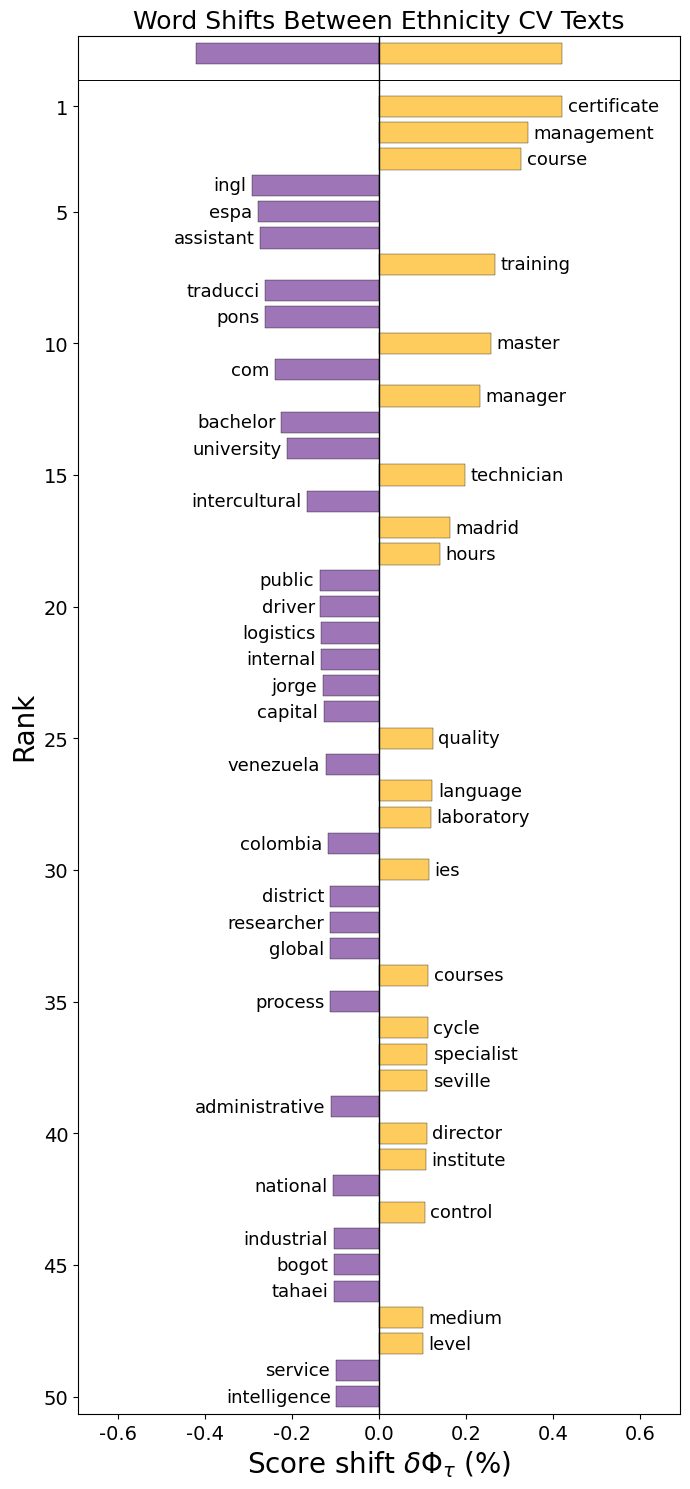

Creating Jensen-Shannon Divergence shift...
Generating JSD word shift graph...


/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


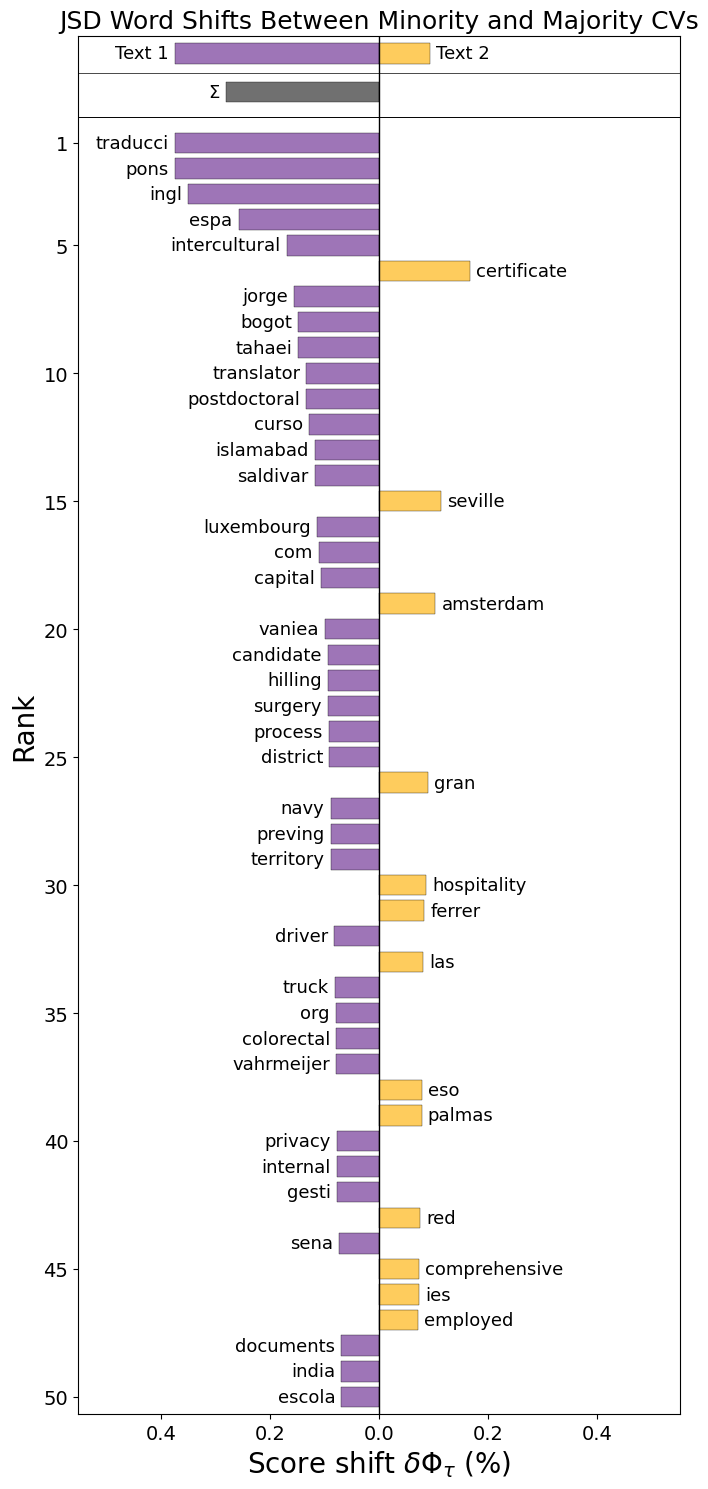


Step 4: Analyzing sentiment shifts
Trying lexicon: vader
Lexicon 'vader' error: Lexicon does not exist in Shifterator: vader
Trying lexicon: afinn
Lexicon 'afinn' error: Lexicon does not exist in Shifterator: afinn
Trying lexicon: nrc
Lexicon 'nrc' error: Lexicon does not exist in Shifterator: nrc
Trying lexicon: bing
Lexicon 'bing' error: Lexicon does not exist in Shifterator: bing
Trying lexicon: labMT
Lexicon 'labMT' error: Lexicon does not exist in Shifterator: labMT
Trying lexicon: hedonometer
Lexicon 'hedonometer' error: Lexicon does not exist in Shifterator: hedonometer
No pre-built lexicons are available. Please install a sentiment lexicon package.

Step 5: Analyzing entropy shifts
Analyzing entropy shifts between Minority and Majority CVs
Generating entropy shift graph...


/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


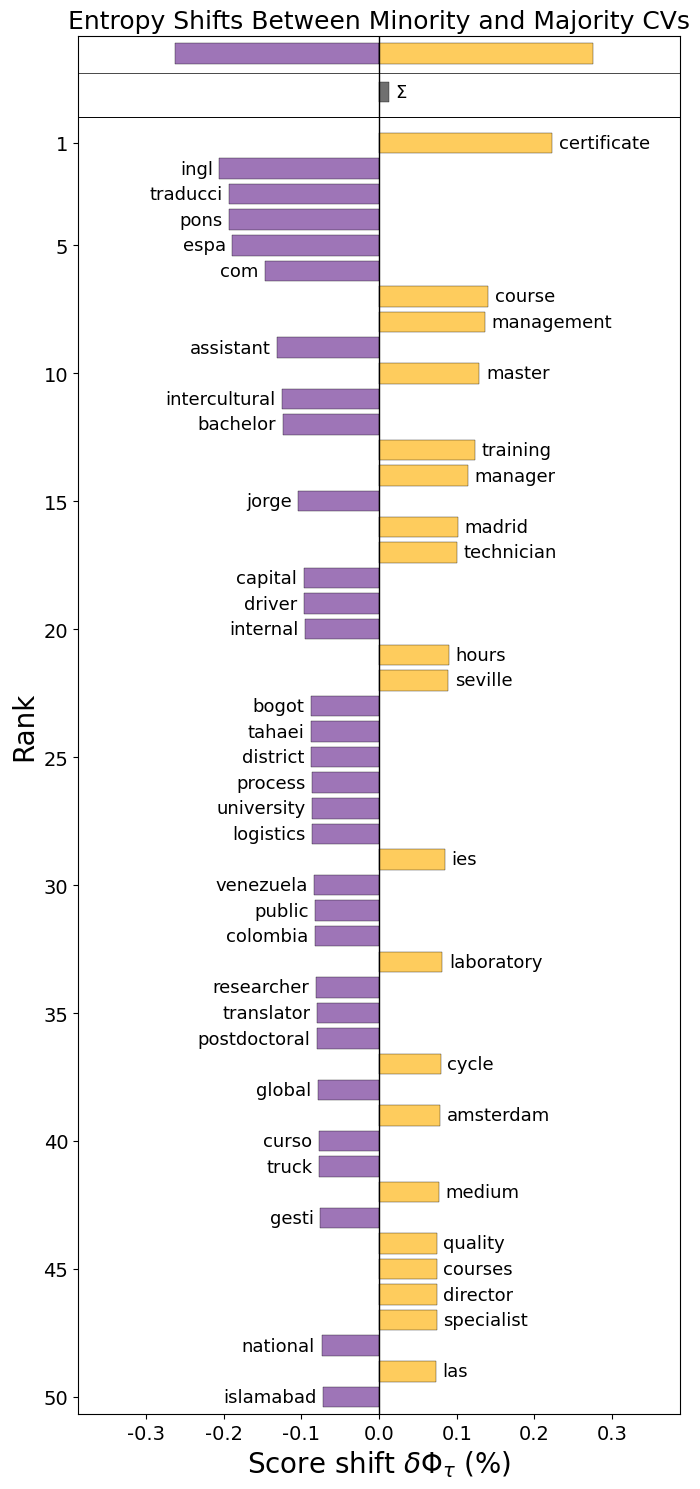

Shannon entropy for Minority CVs: 10.9417 bits
Shannon entropy for Majority CVs: 11.1921 bits
Majority CVs use more diverse and unpredictable language

Step 6: Analyzing KL divergence
Analyzing KL Divergence from Minority to Majority CVs
Generating KL divergence shift graph...


/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


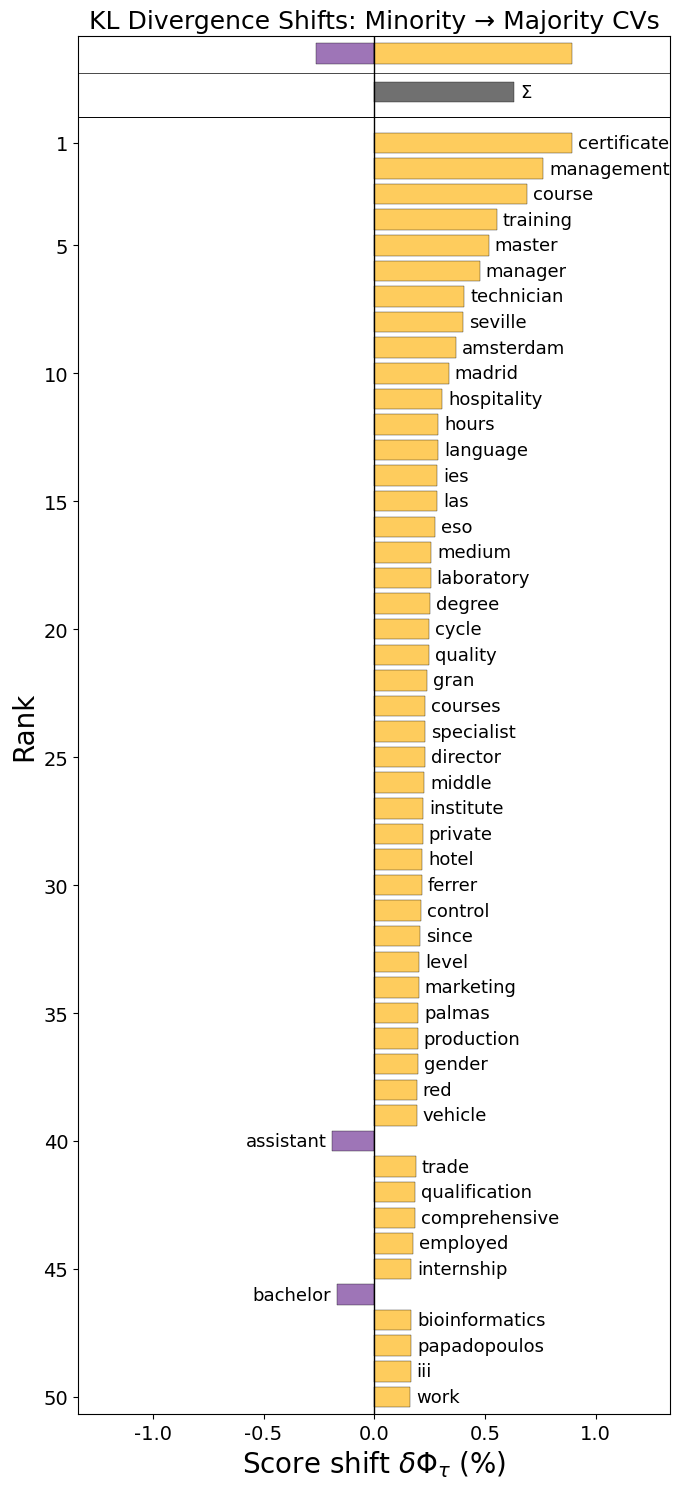

Analyzing KL Divergence from Majority to Minority CVs


/usr/local/lib/python3.11/dist-packages/shifterator/plotting.py:604: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


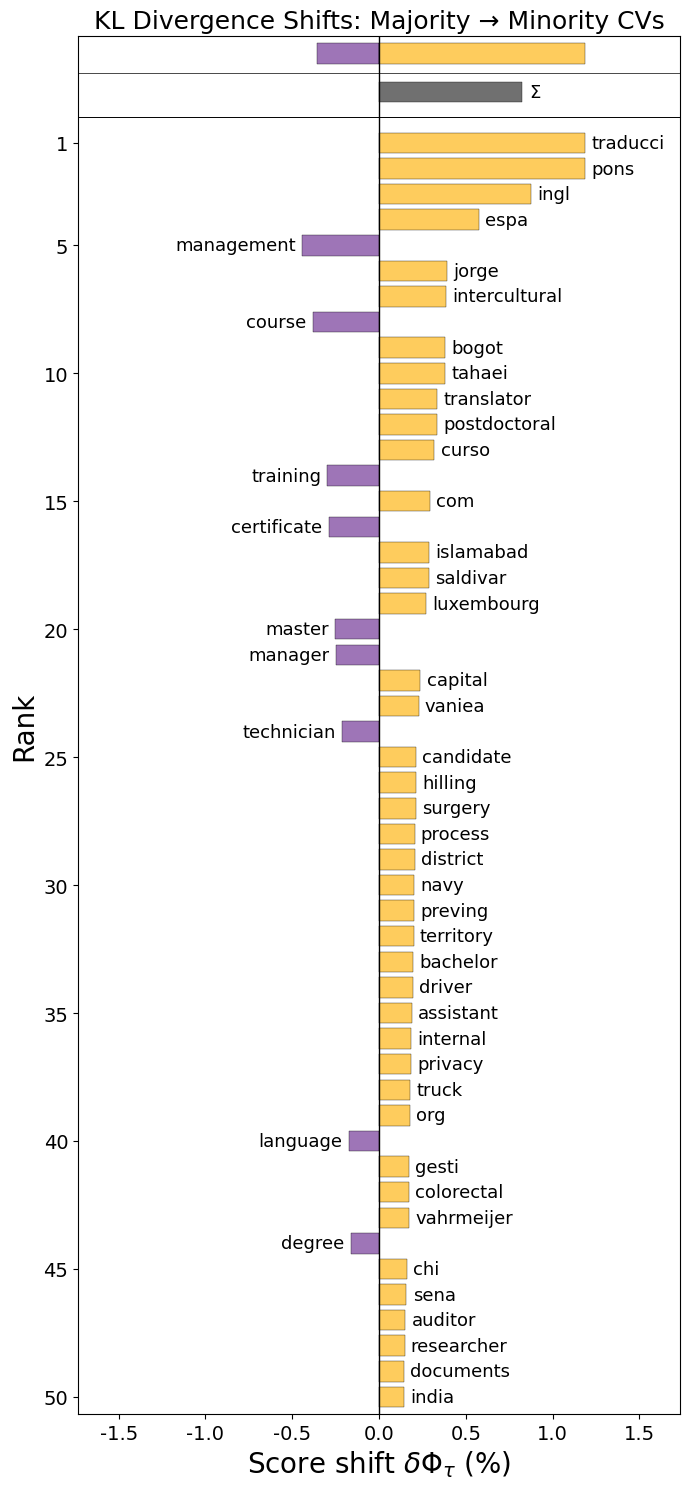


Step 7: Analyzing word categories
Analyzing word categories between Minority and Majority CVs

Word Category Analysis:
Category                  | Minority        | Majority        | Difference
----------------------------------------------------------------------
Technical Skills          |          4.06% |          4.00% |     -0.06%
Soft Skills               |          2.70% |          3.03% |     +0.33%
Education                 |          4.89% |          5.09% |     +0.21%
International Experience  |          1.64% |          1.52% |     -0.12%
Professional Experience   |          3.37% |          3.38% |     +0.01%
Achievements              |          3.07% |          3.47% |     +0.39%
Community Involvement     |          2.47% |          2.03% |     -0.44%


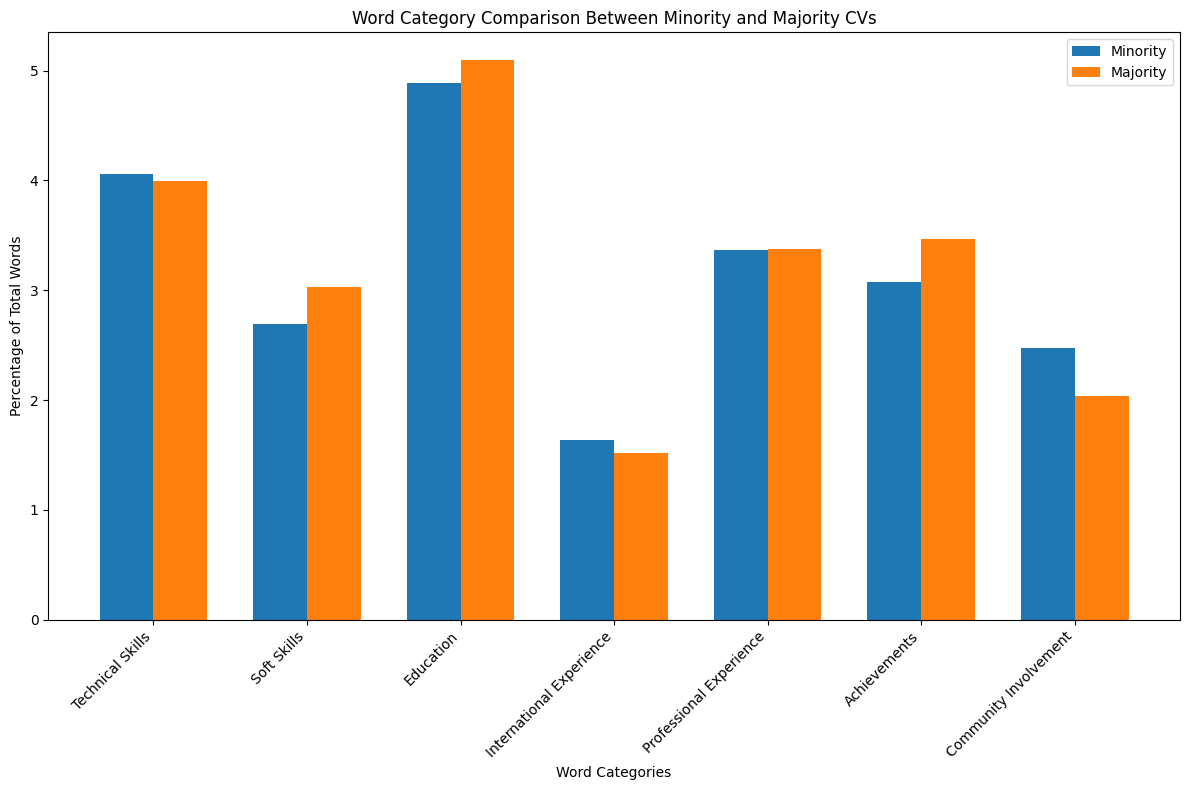


Step 8: Analyzing education and experience patterns
Analyzing education and experience patterns between Minority and Majority CVs

Education & Experience Pattern Analysis:

Educational Institutions Pattern:
  Minority: 2.24%
  Majority: 2.10%
  Difference: -0.14%
  Most different terms:
    - 'university': Minority 1.31%, Majority 1.14% (diff: -0.17%)
    - 'institute': Minority 0.22%, Majority 0.30% (diff: +0.08%)
    - 'school': Minority 0.53%, Majority 0.50% (diff: -0.03%)

Degree Types Pattern:
  Minority: 9.93%
  Majority: 10.77%
  Difference: +0.84%
  Most different terms:
    - 'ma': Minority 6.10%, Majority 7.14% (diff: +1.03%)
    - 'ba': Minority 2.16%, Majority 1.60% (diff: -0.56%)
    - 'certificate': Minority 0.32%, Majority 0.65% (diff: +0.33%)

Study Fields Pattern:
  Minority: 4.74%
  Majority: 4.93%
  Difference: +0.19%
  Most different terms:
    - 'management': Minority 1.19%, Majority 1.45% (diff: +0.26%)
    - 'marketing': Minority 0.28%, Majority 0.35% (diff: +0.

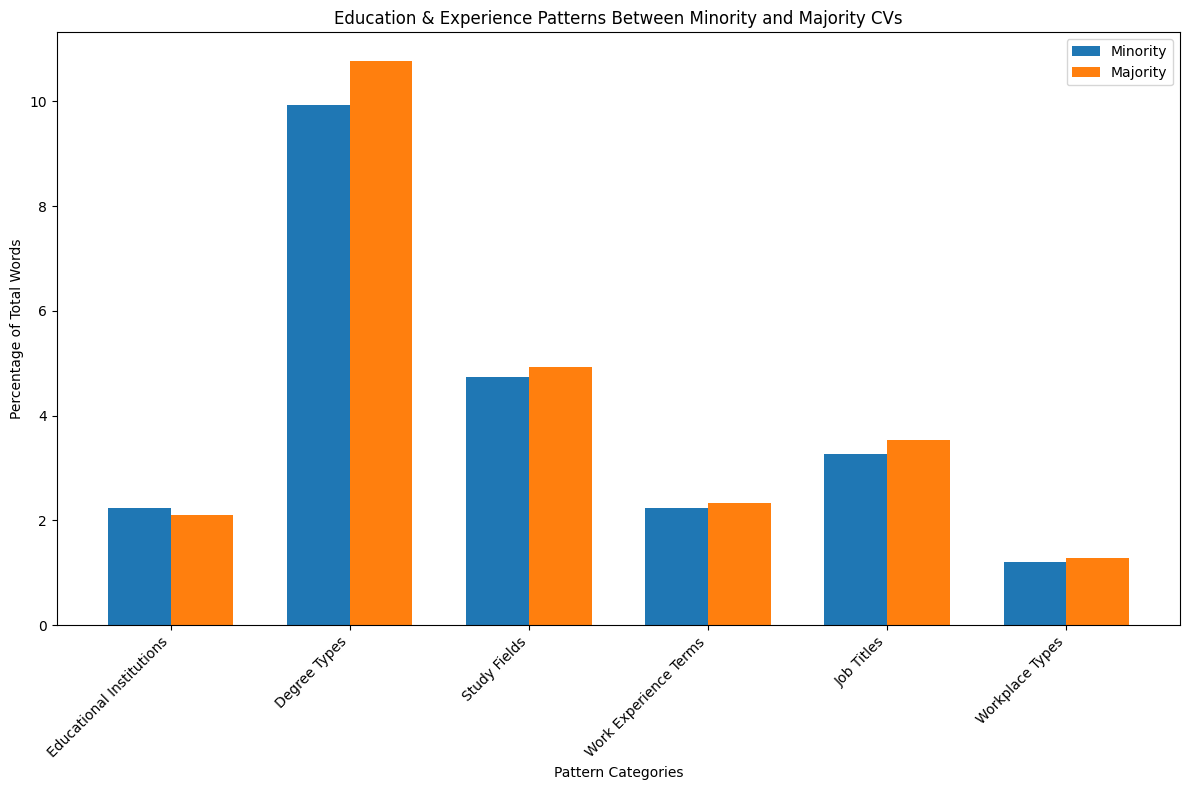


Key Insights from Ethnicity Language Analysis:
Words more distinctive of Majority CVs: certificate, management, course, training, master, manager, technician, madrid, hours, quality
Words more distinctive of Minority CVs: ingl, espa, assistant, traducci, pons, com, bachelor, university, intercultural, public

Entropy Analysis:
Minority entropy: 10.9417 bits
Majority entropy: 11.1921 bits
Majority CVs use more diverse and unpredictable language

Category Analysis Highlights:

Education & Experience Pattern Highlights:
- Majority CVs mention 0.8% more degree types terms

Shifterator ethnicity analysis complete!


In [ ]:
# Shifterator Analysis - Ethnicity Differences in CVs
import shifterator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import os
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords

# Fix collections.Mapping deprecation in Python 3.10+
import collections
import collections.abc
if not hasattr(collections, 'Mapping'):
    collections.Mapping = collections.abc.Mapping

# Download necessary NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# 1. Load the processed data with ethnicity labels
# Assumes the ethnicity classification model has been run
# If not, we can load from the saved CSV
ETHNICITY_DATA_DIR = os.path.join(DATA_PATH, 'ethnicity')
train_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_train.csv')
val_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_val.csv')
test_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_test.csv')

# Load and combine datasets for analysis
def load_ethnicity_data():
    """Load and combine ethnicity data for analysis"""
    print("Loading ethnicity datasets...")

    # Load the split datasets
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    # Filter out 'Both' category if it exists (for binary analysis)
    train_df = train_df[train_df['ethnicity'] != 'Both']
    val_df = val_df[val_df['ethnicity'] != 'Both']
    test_df = test_df[test_df['ethnicity'] != 'Both']

    # Combine them for analysis
    combined_df = pd.concat([train_df, val_df, test_df])

    print(f"Loaded {len(combined_df)} CV records with ethnicity labels")
    print(f"Ethnicity distribution: {combined_df['ethnicity'].value_counts().to_dict()}")

    return combined_df

# 2. Group CV texts by ethnicity
def prepare_text_by_ethnicity(df, text_column='cv_text', ethnicity_column='ethnicity'):
    """Group and prepare text by ethnicity category"""
    ethnicity_texts = {}

    # Group texts by ethnicity
    for ethnicity in df[ethnicity_column].unique():
        texts = df[df[ethnicity_column] == ethnicity][text_column].tolist()
        ethnicity_texts[ethnicity] = ' '.join(texts)

    return ethnicity_texts

# 3. Create word frequency dictionaries for Shifterator
def create_word_freq_dicts(ethnicity_texts, min_word_length=3, additional_stopwords=None):
    """
    Create word frequency dictionaries for each ethnicity

    Parameters:
    -----------
    ethnicity_texts : dict
        Keys are ethnicity labels, values are combined text for each ethnicity
    min_word_length : int
        Minimum word length to include
    additional_stopwords : list
        Additional stopwords to exclude beyond the NLTK English stopwords

    Returns:
    --------
    dict
        Keys are ethnicity labels, values are dictionaries of word frequencies
    """

    ethnicity_freq_dicts = {}
    stop_words = set(stopwords.words('english'))

    # Add custom stopwords common in CVs
    cv_stopwords = {'resume', 'cv', 'curriculum', 'vitae', 'email', 'phone',
                   'address', 'linkedin', 'github', 'http', 'https', 'www'}

    if additional_stopwords:
        cv_stopwords.update(additional_stopwords)

    stop_words.update(cv_stopwords)

    for ethnicity, text in ethnicity_texts.items():
        # Clean text: lowercase, remove non-alphabetic characters
        text = text.lower()
        text = re.sub(r'[^a-z\s]', ' ', text)

        # Tokenize
        words = word_tokenize(text)

        # Filter words: remove stopwords and short words
        words = [word for word in words
                if word not in stop_words and len(word) >= min_word_length]

        # Count frequencies
        word_counts = Counter(words)

        ethnicity_freq_dicts[ethnicity] = dict(word_counts)

    return ethnicity_freq_dicts

# 4. Perform Shifterator analysis of word proportions and visualize results
def analyze_ethnicity_word_shifts(ethnicity_freq_dicts, top_n=50, plot_title="Word Shifts Between Ethnicity CV Texts"):
    """
    Analyze and visualize word shifts between ethnicities

    Parameters:
    -----------
    ethnicity_freq_dicts : dict
        Keys are ethnicity labels, values are dictionaries of word frequencies
    top_n : int
        Number of top words to display in the shift graph
    plot_title : str
        Title for the shift graph
    """

    if len(ethnicity_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 ethnicity categories")

    ethnicities = list(ethnicity_freq_dicts.keys())
    ethnicity1, ethnicity2 = ethnicities[0], ethnicities[1]

    print(f"Analyzing word shifts between {ethnicity1} and {ethnicity2} CVs")

    # Create a simple shift (proportion shift)
    print("Creating proportion shift...")
    prop_shift = shifterator.shifts.ProportionShift(
        type2freq_1=ethnicity_freq_dicts[ethnicity1],
        type2freq_2=ethnicity_freq_dicts[ethnicity2]
    )

    # Create and display the shift graph
    print(f"Generating word shift graph for top {top_n} words...")
    # Use a simplified approach without cumulative_inset to avoid errors
    ax = prop_shift.get_shift_graph(
        top_n=top_n,
        title=plot_title,
        cumulative_inset=False,
        text_size_inset=False,
        show_plot=True
    )

    # Create JSD shift for more detailed analysis
    print("Creating Jensen-Shannon Divergence shift...")
    jsd_shift = shifterator.shifts.JSDivergenceShift(
        type2freq_1=ethnicity_freq_dicts[ethnicity1],
        type2freq_2=ethnicity_freq_dicts[ethnicity2]
    )

    # Generate JSD shift graph
    print("Generating JSD word shift graph...")
    # Use a simplified approach without cumulative_inset to avoid errors
    ax2 = jsd_shift.get_shift_graph(
        top_n=top_n,
        title=f"JSD Word Shifts Between {ethnicity1} and {ethnicity2} CVs",
        cumulative_inset=False,
        text_size_inset=False,
        show_plot=True
    )

    return prop_shift, jsd_shift

# 5. Create sentiment analysis shift using a pre-built lexicon
def analyze_sentiment_shifts(ethnicity_freq_dicts, top_n=50):
    """
    Analyze sentiment differences between ethnicity CV texts using pre-built lexicons

    Parameters:
    -----------
    ethnicity_freq_dicts : dict
        Keys are ethnicity labels, values are dictionaries of word frequencies
    top_n : int
        Number of top words to display in the shift graph
    """

    if len(ethnicity_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 ethnicity categories")

    ethnicities = list(ethnicity_freq_dicts.keys())
    ethnicity1, ethnicity2 = ethnicities[0], ethnicities[1]

    # Try different pre-built lexicons
    # Common lexicons often included in text analysis packages
    lexicons_to_try = ['vader', 'afinn', 'nrc', 'bing', 'labMT', 'hedonometer']

    for lexicon_name in lexicons_to_try:
        print(f"Trying lexicon: {lexicon_name}")
        try:
            # Create weighted average shift with the lexicon
            sentiment_shift = shifterator.shifts.WeightedAvgShift(
                type2freq_1=ethnicity_freq_dicts[ethnicity1],
                type2freq_2=ethnicity_freq_dicts[ethnicity2],
                type2score_1=lexicon_name,  # Try this pre-built lexicon
                reference_value='average'
            )

            # If we get here, the lexicon exists!
            print(f"Using pre-built lexicon: {lexicon_name}")

            # Generate weighted average shift graph
            print("Generating sentiment shift graph...")
            ax = sentiment_shift.get_shift_graph(
                top_n=top_n,
                title=f"Sentiment Shifts Between {ethnicity1} and {ethnicity2} CVs ({lexicon_name})",
                cumulative_inset=False,
                text_size_inset=False,
                show_plot=True
            )

            # Calculate average sentiment scores
            avg_score1 = sentiment_shift.get_weighted_score(
                ethnicity_freq_dicts[ethnicity1],
                sentiment_shift.type2score_1
            )

            avg_score2 = sentiment_shift.get_weighted_score(
                ethnicity_freq_dicts[ethnicity2],
                sentiment_shift.type2score_2
            )

            print(f"Average sentiment score for {ethnicity1} CVs: {avg_score1:.4f}")
            print(f"Average sentiment score for {ethnicity2} CVs: {avg_score2:.4f}")

            return sentiment_shift, avg_score1, avg_score2

        except Exception as e:
            print(f"Lexicon '{lexicon_name}' error: {str(e)}")
            # Continue trying other lexicons

    # If we get here, none of the lexicons worked
    print("No pre-built lexicons are available. Please install a sentiment lexicon package.")
    return None, None, None

# 6. Add Entropy Shift Analysis
def analyze_entropy_shifts(ethnicity_freq_dicts, top_n=50):
    """
    Analyze entropy differences between ethnicity CV texts

    Parameters:
    -----------
    ethnicity_freq_dicts : dict
        Keys are ethnicity labels, values are dictionaries of word frequencies
    top_n : int
        Number of top words to display in the shift graph
    """

    if len(ethnicity_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 ethnicity categories")

    ethnicities = list(ethnicity_freq_dicts.keys())
    ethnicity1, ethnicity2 = ethnicities[0], ethnicities[1]

    print(f"Analyzing entropy shifts between {ethnicity1} and {ethnicity2} CVs")

    # Create entropy shift
    entropy_shift = shifterator.shifts.EntropyShift(
        type2freq_1=ethnicity_freq_dicts[ethnicity1],
        type2freq_2=ethnicity_freq_dicts[ethnicity2],
        base=2,  # Use base 2 for bits
        alpha=1.0  # Standard Shannon entropy
    )

    # Generate entropy shift graph
    print("Generating entropy shift graph...")
    ax = entropy_shift.get_shift_graph(
        top_n=top_n,
        title=f"Entropy Shifts Between {ethnicity1} and {ethnicity2} CVs",
        cumulative_inset=False,
        text_size_inset=False,
        show_plot=True
    )

    # Print overall entropy values
    type2freq_1 = ethnicity_freq_dicts[ethnicity1]
    type2freq_2 = ethnicity_freq_dicts[ethnicity2]

    # Calculate total frequencies
    total_1 = sum(type2freq_1.values())
    total_2 = sum(type2freq_2.values())

    # Create probability distributions
    prob_dist_1 = {word: count/total_1 for word, count in type2freq_1.items()}
    prob_dist_2 = {word: count/total_2 for word, count in type2freq_2.items()}

    # Calculate Shannon entropy
    from math import log2
    entropy_1 = -sum(p * log2(p) for p in prob_dist_1.values() if p > 0)
    entropy_2 = -sum(p * log2(p) for p in prob_dist_2.values() if p > 0)

    print(f"Shannon entropy for {ethnicity1} CVs: {entropy_1:.4f} bits")
    print(f"Shannon entropy for {ethnicity2} CVs: {entropy_2:.4f} bits")

    if entropy_1 > entropy_2:
        print(f"{ethnicity1} CVs use more diverse and unpredictable language")
    else:
        print(f"{ethnicity2} CVs use more diverse and unpredictable language")

    return entropy_shift, entropy_1, entropy_2

# 7. Add KL Divergence Analysis
def analyze_kl_divergence(ethnicity_freq_dicts, top_n=50):
    """
    Analyze KL Divergence between ethnicity CV texts

    Parameters:
    -----------
    ethnicity_freq_dicts : dict
        Keys are ethnicity labels, values are dictionaries of word frequencies
    top_n : int
        Number of top words to display in the shift graph
    """

    if len(ethnicity_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 ethnicity categories")

    ethnicities = list(ethnicity_freq_dicts.keys())
    ethnicity1, ethnicity2 = ethnicities[0], ethnicities[1]

    print(f"Analyzing KL Divergence from {ethnicity1} to {ethnicity2} CVs")

    # Need to ensure all words appear in both distributions for KL divergence
    all_words = set(ethnicity_freq_dicts[ethnicity1].keys()) | set(ethnicity_freq_dicts[ethnicity2].keys())

    # Create modified frequency dictionaries with all words
    mod_freq_1 = ethnicity_freq_dicts[ethnicity1].copy()
    mod_freq_2 = ethnicity_freq_dicts[ethnicity2].copy()

    # Add smoothing for words that don't appear in one corpus
    for word in all_words:
        if word not in mod_freq_1:
            mod_freq_1[word] = 1  # Laplace smoothing
        if word not in mod_freq_2:
            mod_freq_2[word] = 1  # Laplace smoothing

    try:
        # Create KL divergence shift
        kl_shift = shifterator.shifts.KLDivergenceShift(
            type2freq_1=mod_freq_1,
            type2freq_2=mod_freq_2,
            base=2  # Use base 2 for bits
        )

        # Generate KL divergence shift graph
        print("Generating KL divergence shift graph...")
        ax = kl_shift.get_shift_graph(
            top_n=top_n,
            title=f"KL Divergence Shifts: {ethnicity1} → {ethnicity2} CVs",
            cumulative_inset=False,
            text_size_inset=False,
            show_plot=True
        )

        # Also try reverse direction
        print(f"Analyzing KL Divergence from {ethnicity2} to {ethnicity1} CVs")
        kl_shift_reverse = shifterator.shifts.KLDivergenceShift(
            type2freq_1=mod_freq_2,
            type2freq_2=mod_freq_1,
            base=2  # Use base 2 for bits
        )

        ax2 = kl_shift_reverse.get_shift_graph(
            top_n=top_n,
            title=f"KL Divergence Shifts: {ethnicity2} → {ethnicity1} CVs",
            cumulative_inset=False,
            text_size_inset=False,
            show_plot=True
        )

        return kl_shift, kl_shift_reverse

    except Exception as e:
        print(f"KL Divergence analysis error: {str(e)}")
        return None, None

# 8. Word Category Analysis - Ethnicity Specific
def analyze_word_categories(ethnicity_freq_dicts):
    """
    Analyze differences in word categories between ethnicity CV texts

    Parameters:
    -----------
    ethnicity_freq_dicts : dict
        Keys are ethnicity labels, values are dictionaries of word frequencies
    """

    if len(ethnicity_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 ethnicity categories")

    ethnicities = list(ethnicity_freq_dicts.keys())
    ethnicity1, ethnicity2 = ethnicities[0], ethnicities[1]

    print(f"Analyzing word categories between {ethnicity1} and {ethnicity2} CVs")

    # Define word categories relevant to CVs and potentially to ethnicity differences
    categories = {
        'technical_skills': [
            'programming', 'software', 'hardware', 'database', 'network', 'system',
            'code', 'develop', 'algorithm', 'analysis', 'technical', 'computer',
            'engineering', 'design', 'implement', 'technology', 'architecture'
        ],
        'soft_skills': [
            'communication', 'leadership', 'teamwork', 'collaboration', 'interpersonal',
            'organize', 'manage', 'coordinate', 'facilitate', 'negotiate', 'present',
            'adaptable', 'flexible', 'creative', 'innovative', 'problem-solving'
        ],
        'education': [
            'university', 'college', 'degree', 'bachelor', 'master', 'phd', 'doctorate',
            'thesis', 'dissertation', 'graduate', 'academic', 'study', 'education',
            'major', 'minor', 'certificate', 'diploma', 'school', 'gpa'
        ],
        'international_experience': [
            'international', 'global', 'abroad', 'foreign', 'multicultural', 'diverse',
            'bilingual', 'multilingual', 'language', 'cultural', 'worldwide', 'overseas',
            'travel', 'exchange', 'country', 'countries', 'world', 'diversity'
        ],
        'professional_experience': [
            'experience', 'job', 'work', 'position', 'role', 'career', 'professional',
            'industry', 'company', 'business', 'corporate', 'employer', 'supervisor',
            'employee', 'employment', 'responsibility', 'task', 'duty'
        ],
        'achievements': [
            'achieve', 'success', 'award', 'recognition', 'honor', 'accomplish',
            'improve', 'increase', 'decrease', 'optimize', 'enhance', 'develop',
            'create', 'implement', 'launch', 'lead', 'manage', 'direct', 'supervise'
        ],
        'community_involvement': [
            'community', 'volunteer', 'service', 'organization', 'social', 'nonprofit',
            'charity', 'civic', 'public', 'outreach', 'advocacy', 'mentor', 'teach',
            'help', 'support', 'contribute', 'participate', 'society', 'cultural'
        ]
    }

    # Calculate category scores for each ethnicity
    category_scores = {}

    for category, words in categories.items():
        category_scores[category] = {}

        for ethnicity, freq_dict in ethnicity_freq_dicts.items():
            # Get total word count for this ethnicity
            total_words = sum(freq_dict.values())

            # Count words in this category
            category_count = 0
            for word in words:
                # Match partial words (e.g., "program" would match "programming", "programmer", etc.)
                for cv_word, count in freq_dict.items():
                    if word in cv_word:
                        category_count += count

            # Calculate percentage
            category_scores[category][ethnicity] = (category_count / total_words) * 100

    # Print and visualize results
    print("\nWord Category Analysis:")

    # Create lists for plotting
    categories_list = list(categories.keys())
    ethnicity1_scores = [category_scores[cat][ethnicity1] for cat in categories_list]
    ethnicity2_scores = [category_scores[cat][ethnicity2] for cat in categories_list]

    # Print table of results
    print(f"{'Category':<25} | {ethnicity1:<15} | {ethnicity2:<15} | Difference")
    print("-" * 70)

    for i, category in enumerate(categories_list):
        diff = ethnicity2_scores[i] - ethnicity1_scores[i]
        print(f"{category.replace('_', ' ').title():<25} | {ethnicity1_scores[i]:>13.2f}% | {ethnicity2_scores[i]:>13.2f}% | {diff:>+9.2f}%")

    # Create bar chart
    plt.figure(figsize=(12, 8))

    x = range(len(categories_list))
    width = 0.35

    plt.bar([i - width/2 for i in x], ethnicity1_scores, width=width, label=ethnicity1)
    plt.bar([i + width/2 for i in x], ethnicity2_scores, width=width, label=ethnicity2)

    plt.xlabel('Word Categories')
    plt.ylabel('Percentage of Total Words')
    plt.title(f'Word Category Comparison Between {ethnicity1} and {ethnicity2} CVs')

    plt.xticks(x, [c.replace('_', ' ').title() for c in categories_list], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return category_scores

# 9. Education & Experience Pattern Analysis
def analyze_education_experience_patterns(ethnicity_freq_dicts):
    """
    Specialized analysis of education and experience patterns by ethnicity

    Parameters:
    -----------
    ethnicity_freq_dicts : dict
        Keys are ethnicity labels, values are dictionaries of word frequencies
    """

    if len(ethnicity_freq_dicts) != 2:
        raise ValueError("This analysis requires exactly 2 ethnicity categories")

    ethnicities = list(ethnicity_freq_dicts.keys())
    ethnicity1, ethnicity2 = ethnicities[0], ethnicities[1]

    print(f"Analyzing education and experience patterns between {ethnicity1} and {ethnicity2} CVs")

    # Define pattern categories
    patterns = {
        'educational_institutions': [
            'university', 'college', 'school', 'institute', 'academy'
        ],
        'degree_types': [
            'bachelor', 'master', 'phd', 'doctorate', 'diploma', 'certificate',
            'mba', 'bsc', 'msc', 'ba', 'ma', 'associate'
        ],
        'study_fields': [
            'computer', 'engineering', 'science', 'business', 'management',
            'arts', 'humanities', 'social', 'economics', 'finance', 'marketing',
            'mathematics', 'physics', 'chemistry', 'biology', 'medicine', 'law'
        ],
        'work_experience_terms': [
            'experience', 'work', 'job', 'career', 'position', 'role',
            'employment', 'industry', 'professional', 'occupation'
        ],
        'job_titles': [
            'manager', 'director', 'engineer', 'developer', 'analyst',
            'assistant', 'coordinator', 'specialist', 'technician', 'supervisor',
            'administrator', 'consultant', 'officer', 'executive', 'associate'
        ],
        'workplace_types': [
            'company', 'corporation', 'organization', 'firm', 'agency',
            'department', 'office', 'enterprise', 'institute', 'bureau'
        ]
    }

    # Calculate pattern scores for each ethnicity
    pattern_scores = {}

    for pattern, terms in patterns.items():
        pattern_scores[pattern] = {}

        for ethnicity, freq_dict in ethnicity_freq_dicts.items():
            # Get total word count for this ethnicity
            total_words = sum(freq_dict.values())

            # Count terms in this pattern
            pattern_count = 0
            term_counts = {}

            for term in terms:
                term_count = 0
                for cv_word, count in freq_dict.items():
                    if term in cv_word:
                        term_count += count

                term_counts[term] = term_count
                pattern_count += term_count

            # Calculate percentage
            pattern_scores[pattern][ethnicity] = {
                'total': (pattern_count / total_words) * 100,
                'terms': {term: (count / total_words) * 100 for term, count in term_counts.items()}
            }

    # Print results
    print("\nEducation & Experience Pattern Analysis:")

    for pattern, scores in pattern_scores.items():
        print(f"\n{pattern.replace('_', ' ').title()} Pattern:")
        print(f"  {ethnicity1}: {scores[ethnicity1]['total']:.2f}%")
        print(f"  {ethnicity2}: {scores[ethnicity2]['total']:.2f}%")
        print(f"  Difference: {scores[ethnicity2]['total'] - scores[ethnicity1]['total']:+.2f}%")

        # Find top 3 most different terms
        term_diffs = []
        for term in patterns[pattern]:
            term1 = scores[ethnicity1]['terms'].get(term, 0)
            term2 = scores[ethnicity2]['terms'].get(term, 0)
            term_diffs.append((term, term2 - term1))

        # Sort by absolute difference
        top_terms = sorted(term_diffs, key=lambda x: abs(x[1]), reverse=True)[:3]

        if top_terms:
            print("  Most different terms:")
            for term, diff in top_terms:
                print(f"    - '{term}': {ethnicity1} {scores[ethnicity1]['terms'].get(term, 0):.2f}%, "
                      f"{ethnicity2} {scores[ethnicity2]['terms'].get(term, 0):.2f}% (diff: {diff:+.2f}%)")

    # Create visualization
    plt.figure(figsize=(12, 8))

    patterns_list = list(patterns.keys())
    ethnicity1_scores = [pattern_scores[pat][ethnicity1]['total'] for pat in patterns_list]
    ethnicity2_scores = [pattern_scores[pat][ethnicity2]['total'] for pat in patterns_list]

    x = range(len(patterns_list))
    width = 0.35

    plt.bar([i - width/2 for i in x], ethnicity1_scores, width=width, label=ethnicity1)
    plt.bar([i + width/2 for i in x], ethnicity2_scores, width=width, label=ethnicity2)

    plt.xlabel('Pattern Categories')
    plt.ylabel('Percentage of Total Words')
    plt.title(f'Education & Experience Patterns Between {ethnicity1} and {ethnicity2} CVs')

    plt.xticks(x, [p.replace('_', ' ').title() for p in patterns_list], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pattern_scores

# 10. Main analysis function
def run_ethnicity_language_analysis(df=None, text_column='cv_text', ethnicity_column='ethnicity'):
    """
    Run the complete ethnicity language analysis pipeline
    """
    print("\nPerforming Ethnicity Language Analysis with Shifterator")
    print("----------------------------------------------------")

    # Load data if not provided
    if df is None:
        df = load_ethnicity_data()

    # Prepare texts by ethnicity
    print("\nStep 1: Preparing texts by ethnicity")
    ethnicity_texts = prepare_text_by_ethnicity(df, text_column, ethnicity_column)

    # Generate word frequency dictionaries
    print("\nStep 2: Creating word frequency dictionaries")
    ethnicity_freq_dicts = create_word_freq_dicts(ethnicity_texts)

    # Get vocabulary statistics
    print("\nVocabulary Statistics:")
    for ethnicity, freq_dict in ethnicity_freq_dicts.items():
        total_words = sum(freq_dict.values())
        unique_words = len(freq_dict)
        print(f"{ethnicity} CVs: {total_words} total words, {unique_words} unique words")

    # Analyze word proportion shifts
    print("\nStep 3: Analyzing word proportion shifts")
    prop_shift, jsd_shift = analyze_ethnicity_word_shifts(ethnicity_freq_dicts)

    # Analyze sentiment shifts
    print("\nStep 4: Analyzing sentiment shifts")
    try:
        sentiment_shift, avg_score1, avg_score2 = analyze_sentiment_shifts(ethnicity_freq_dicts)
        sentiment_analysis_successful = sentiment_shift is not None
    except Exception as e:
        print(f"Sentiment analysis error: {str(e)}")
        print("Skipping sentiment analysis")
        sentiment_analysis_successful = False

    # Analyze entropy shifts
    print("\nStep 5: Analyzing entropy shifts")
    try:
        entropy_shift, entropy1, entropy2 = analyze_entropy_shifts(ethnicity_freq_dicts)
        entropy_analysis_successful = True
    except Exception as e:
        print(f"Entropy analysis error: {str(e)}")
        print("Skipping entropy analysis")
        entropy_analysis_successful = False

    # Analyze KL divergence
    print("\nStep 6: Analyzing KL divergence")
    try:
        kl_shift, kl_shift_reverse = analyze_kl_divergence(ethnicity_freq_dicts)
        kl_analysis_successful = kl_shift is not None
    except Exception as e:
        print(f"KL divergence analysis error: {str(e)}")
        print("Skipping KL divergence analysis")
        kl_analysis_successful = False

    # Analyze word categories
    print("\nStep 7: Analyzing word categories")
    try:
        category_scores = analyze_word_categories(ethnicity_freq_dicts)
        category_analysis_successful = True
    except Exception as e:
        print(f"Word category analysis error: {str(e)}")
        print("Skipping word category analysis")
        category_analysis_successful = False

    # Analyze education and experience patterns
    print("\nStep 8: Analyzing education and experience patterns")
    try:
        pattern_scores = analyze_education_experience_patterns(ethnicity_freq_dicts)
        pattern_analysis_successful = True
    except Exception as e:
        print(f"Pattern analysis error: {str(e)}")
        print("Skipping pattern analysis")
        pattern_analysis_successful = False

    # Generate interpretable insights
    print("\nKey Insights from Ethnicity Language Analysis:")
    ethnicities = list(ethnicity_freq_dicts.keys())

    # Get top distinctive words for each ethnicity
    shift_scores = prop_shift.get_shift_scores()
    sorted_words = sorted(shift_scores.items(), key=lambda x: x[1])

    # Words more common in ethnicity 2
    top_ethnicity2_words = [word for word, score in sorted_words[-10:]]
    # Words more common in ethnicity 1
    top_ethnicity1_words = [word for word, score in sorted_words[:10]]

    print(f"Words more distinctive of {ethnicities[1]} CVs: {', '.join(reversed(top_ethnicity2_words))}")
    print(f"Words more distinctive of {ethnicities[0]} CVs: {', '.join(top_ethnicity1_words)}")

    if sentiment_analysis_successful:
        sentiment_diff = avg_score2 - avg_score1
        if abs(sentiment_diff) > 0.1:  # Threshold for meaningful difference
            higher_ethnicity = ethnicities[1] if sentiment_diff > 0 else ethnicities[0]
            print(f"{higher_ethnicity} CVs use more positive language overall")
        else:
            print("No substantial difference in overall sentiment between ethnicities")

    if entropy_analysis_successful:
        print(f"\nEntropy Analysis:")
        print(f"{ethnicities[0]} entropy: {entropy1:.4f} bits")
        print(f"{ethnicities[1]} entropy: {entropy2:.4f} bits")
        higher_entropy = ethnicities[0] if entropy1 > entropy2 else ethnicities[1]
        print(f"{higher_entropy} CVs use more diverse and unpredictable language")

    if category_analysis_successful:
        print("\nCategory Analysis Highlights:")
        # Find most distinctive categories
        for category, scores in category_scores.items():
            diff = scores[ethnicities[1]] - scores[ethnicities[0]]
            if abs(diff) > 1.0:  # Only report substantial differences
                if diff > 0:
                    print(f"- {ethnicities[1]} CVs use {diff:.1f}% more {category.replace('_', ' ')} terms")
                else:
                    print(f"- {ethnicities[0]} CVs use {-diff:.1f}% more {category.replace('_', ' ')} terms")

    if pattern_analysis_successful:
        print("\nEducation & Experience Pattern Highlights:")
        # Find most distinctive patterns
        for pattern, scores in pattern_scores.items():
            diff = scores[ethnicities[1]]['total'] - scores[ethnicities[0]]['total']
            if abs(diff) > 0.5:  # Only report substantial differences
                if diff > 0:
                    print(f"- {ethnicities[1]} CVs mention {diff:.1f}% more {pattern.replace('_', ' ')} terms")
                else:
                    print(f"- {ethnicities[0]} CVs mention {-diff:.1f}% more {pattern.replace('_', ' ')} terms")

    print("\nShifterator ethnicity analysis complete!")

    return {
        'ethnicity_texts': ethnicity_texts,
        'ethnicity_freq_dicts': ethnicity_freq_dicts,
        'proportion_shift': prop_shift,
        'jsd_shift': jsd_shift,
        'sentiment_shift': sentiment_shift if sentiment_analysis_successful else None,
        'entropy_shift': entropy_shift if entropy_analysis_successful else None,
        'kl_shift': kl_shift if kl_analysis_successful else None,
        'category_scores': category_scores if category_analysis_successful else None,
        'pattern_scores': pattern_scores if pattern_analysis_successful else None
    }

# Execute the analysis if the ethnicity data is available
if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
    results = run_ethnicity_language_analysis()
else:
    print("Ethnicity dataset files not found. Please run the ethnicity classification code first.")

this guy is part of old code, shouldn't really run

In [ ]:
"""
Compare mBERT and XLM-RoBERTa models for ethnicity prediction
"""

from google.colab import drive
import sys
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, XLMRobertaTokenizer

# Mount Drive
drive.mount('/content/drive')

# Set paths based on your structure
PROJECT_ROOT = '/content/drive/MyDrive/anonymised_CVs_classification'
MODULE_PATH = os.path.join(PROJECT_ROOT, 'modules')
CONFIG_PATH = os.path.join(PROJECT_ROOT, 'attribute_configs')
DATA_PATH = os.path.join(PROJECT_ROOT, 'data')
ETHNICITY_DATA_DIR = os.path.join(DATA_PATH, 'ethnicity')
COMPARISON_DIR = os.path.join(PROJECT_ROOT, 'models', 'comparison')

# Create directories if they don't exist
os.makedirs(COMPARISON_DIR, exist_ok=True)
os.makedirs(os.path.join(COMPARISON_DIR, 'plots'), exist_ok=True)

# Add paths to sys.path for importing
sys.path.append(MODULE_PATH)
sys.path.append(CONFIG_PATH)

# Import needed modules
import model_utils
import text_utils
import viz_utils

# Models to compare
MODELS_TO_COMPARE = [
    {
        'name': 'mBERT',
        'type': 'bert-base-multilingual-cased',
        'batch_size': 8,
        'epochs': 3  # Reduced for comparison
    },
    {
        'name': 'XLM-RoBERTa',
        'type': 'xlm-roberta-base',
        'batch_size': 8,
        'epochs': 3  # Reduced for comparison
    }
]

def main():
    print("Starting ethnicity model comparison...")

    # Step 1: Load the optimized data or create it if it doesn't exist
    train_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_train.csv')
    val_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_val.csv')
    test_path = os.path.join(ETHNICITY_DATA_DIR, 'ethnicity_test.csv')

    if not all(os.path.exists(p) for p in [train_path, val_path, test_path]):
        print("Error: Data splits not found. Please run process_ethnicity_real_data.py first.")
        return

    # Load data
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    print(f"Loaded data splits:")
    print(f"  Train: {len(train_df)} records")
    print(f"  Validation: {len(val_df)} records")
    print(f"  Test: {len(test_df)} records")

    # Create label mappings
    unique_ethnicities = sorted(train_df['ethnicity'].unique())
    label_map = {ethnicity: i for i, ethnicity in enumerate(unique_ethnicities)}
    inv_label_map = {i: ethnicity for ethnicity, i in label_map.items()}

    # Results to store comparison metrics
    results = []

    # Step 2: Train and evaluate each model
    for model_config in MODELS_TO_COMPARE:
        model_name = model_config['name']
        model_type = model_config['type']
        batch_size = model_config['batch_size']
        epochs = model_config['epochs']

        print(f"\n{'='*50}")
        print(f"Processing {model_name} model")
        print(f"{'='*50}")

        # Get the right tokenizer
        if 'bert' in model_type.lower():
            tokenizer = BertTokenizer.from_pretrained(model_type)
        elif 'roberta' in model_type.lower():
            tokenizer = XLMRobertaTokenizer.from_pretrained(model_type)
        else:
            print(f"Unsupported model type: {model_type}")
            continue

        # Optimize text for this specific tokenizer
        model_prefix = model_name.lower().replace('-', '_')
        train_opt_path = os.path.join(ETHNICITY_DATA_DIR, f'ethnicity_train_{model_prefix}.csv')
        val_opt_path = os.path.join(ETHNICITY_DATA_DIR, f'ethnicity_val_{model_prefix}.csv')
        test_opt_path = os.path.join(ETHNICITY_DATA_DIR, f'ethnicity_test_{model_prefix}.csv')

        # Process data if not already done
        if all(os.path.exists(p) for p in [train_opt_path, val_opt_path, test_opt_path]):
            print(f"Loading existing optimized data for {model_name}")
            train_opt = pd.read_csv(train_opt_path)
            val_opt = pd.read_csv(val_opt_path)
            test_opt = pd.read_csv(test_opt_path)
        else:
            print(f"Optimizing text for {model_name}...")
            train_opt = text_utils.prepare_texts_for_transformers(
                train_df, 'cv_text', tokenizer
            )
            train_opt.to_csv(train_opt_path, index=False)

            val_opt = text_utils.prepare_texts_for_transformers(
                val_df, 'cv_text', tokenizer
            )
            val_opt.to_csv(val_opt_path, index=False)

            test_opt = text_utils.prepare_texts_for_transformers(
                test_df, 'cv_text', tokenizer
            )
            test_opt.to_csv(test_opt_path, index=False)

        # Add labels
        train_opt['label'] = train_opt['ethnicity'].map(label_map)
        val_opt['label'] = val_opt['ethnicity'].map(label_map)
        test_opt['label'] = test_opt['ethnicity'].map(label_map)

        # Create model
        model, _ = model_utils.create_model_and_tokenizer(
            model_type=model_type,
            num_labels=len(unique_ethnicities),
            dropout=0.2
        )

        # Check if GPU is available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        model.to(device)

        # Create datasets and dataloaders
        train_dataset = model_utils.CVDataset(train_opt, tokenizer)
        val_dataset = model_utils.CVDataset(val_opt, tokenizer)
        test_dataset = model_utils.CVDataset(test_opt, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # Model save path
        model_save_path = os.path.join(COMPARISON_DIR, f'ethnicity_{model_prefix}.pt')

        # Train model or load existing
        if os.path.exists(model_save_path):
            print(f"Loading existing {model_name} model from {model_save_path}")
            model.load_state_dict(torch.load(model_save_path))
            metrics = None
        else:
            print(f"Training {model_name} model...")
            start_time = time.time()

            # Train model
            metrics = model_utils.train_model(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                num_epochs=epochs,
                device=device,
                model_save_path=model_save_path
            )

            training_time = time.time() - start_time
            print(f"Training completed in {training_time:.2f} seconds")

        # Evaluate on test set
        print(f"Evaluating {model_name} on test set...")
        test_results = model_utils.evaluate_model(
            model=model,
            test_loader=test_loader,
            device=device,
            label_names=unique_ethnicities
        )

        print(f"Test accuracy: {test_results['test_accuracy']:.4f}")
        print(f"Test F1 score: {test_results['test_f1']:.4f}")

        # Store results
        results.append({
            'name': model_name,
            'accuracy': test_results['test_accuracy'],
            'f1': test_results['test_f1'],
            'confusion_matrix': test_results['confusion_matrix'],
            'class_report': test_results['classification_report']
        })

    # Step 3: Visualize comparison
    if len(results) > 0:
        print("\nGenerating comparison visualizations...")

        # Accuracy and F1 comparison
        plt.figure(figsize=(12, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        model_names = [r['name'] for r in results]
        accuracies = [r['accuracy'] for r in results]

        plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71'])
        plt.title('Accuracy Comparison')
        plt.ylim(0, 1)

        for i, acc in enumerate(accuracies):
            plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')

        # F1 Score
        plt.subplot(1, 2, 2)
        f1_scores = [r['f1'] for r in results]

        plt.bar(model_names, f1_scores, color=['#3498db', '#2ecc71'])
        plt.title('F1 Score Comparison')
        plt.ylim(0, 1)

        for i, f1 in enumerate(f1_scores):
            plt.text(i, f1 + 0.02, f'{f1:.4f}', ha='center')

        plt.tight_layout()
        plt.savefig(os.path.join(COMPARISON_DIR, 'plots', 'ethnicity_model_comparison.png'))

        # Confusion matrices
        plt.figure(figsize=(15, 8))

        for i, result in enumerate(results):
            plt.subplot(1, len(results), i+1)

            sns.heatmap(
                result['confusion_matrix'],
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=unique_ethnicities,
                yticklabels=unique_ethnicities
            )

            plt.title(f'{result["name"]} Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('True')

        plt.tight_layout()
        plt.savefig(os.path.join(COMPARISON_DIR, 'plots', 'ethnicity_confusion_matrices.png'))

        # Write summary to file
        with open(os.path.join(COMPARISON_DIR, 'ethnicity_model_comparison.txt'), 'w') as f:
            f.write("ETHNICITY PREDICTION MODEL COMPARISON\n")
            f.write("==================================\n\n")

            for i, result in enumerate(results):
                f.write(f"Model {i+1}: {result['name']}\n")
                f.write(f"  Accuracy: {result['accuracy']:.4f}\n")
                f.write(f"  F1 Score: {result['f1']:.4f}\n\n")

                f.write("  Classification Report:\n")
                for category in unique_ethnicities:
                    cat_report = result['class_report'][category]
                    f.write(f"    {category}:\n")
                    f.write(f"      Precision: {cat_report['precision']:.4f}\n")
                    f.write(f"      Recall:    {cat_report['recall']:.4f}\n")
                    f.write(f"      F1:        {cat_report['f1-score']:.4f}\n")
                    f.write(f"      Support:   {cat_report['support']}\n\n")

                f.write("-" * 40 + "\n\n")

            # Overall winner
            best_idx = max(range(len(results)), key=lambda i: results[i]['f1'])
            f.write(f"Best model based on F1 score: {results[best_idx]['name']}\n")
            f.write(f"  Accuracy: {results[best_idx]['accuracy']:.4f}\n")
            f.write(f"  F1 Score: {results[best_idx]['f1']:.4f}\n")

        print(f"Comparison results saved to {COMPARISON_DIR}")

    # Step 4: Print final comparison
    print("\nModel Comparison Summary:")
    print("-" * 40)
    for i, result in enumerate(results):
        print(f"{result['name']}:")
        print(f"  Accuracy: {result['accuracy']:.4f}")
        print(f"  F1 Score: {result['f1']:.4f}")

    if len(results) > 1:
        best_idx = max(range(len(results)), key=lambda i: results[i]['f1'])
        print(f"\nBest model: {results[best_idx]['name']}")

if __name__ == "__main__":
    main()